In [1]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from typing import Dict, List, Tuple, Optional
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
import numpy as np
import pandas as pd
from cache_decorator import Cache
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data

C:\Users\gigi_\anaconda3\envs\Bioinformatic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cell_line = 'HEK293'
window_size = 256
threshold_enhancers = 0.1
threshold_promoters = 1
number_holdouts = 10

In [3]:
genome = Genome("hg38")

def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [4]:
def build_binary_classification_perceptron(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns perceptron model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    perceptron = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationPerceptron"
    )

    perceptron.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return perceptron, input_epigenomic_data, output_ffnn

In [5]:
def build_regression_perceptron(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns perceptron model for regression.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    output_ffnn = Dense(1, activation="linear")(input_epigenomic_data)

    perceptron = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="RegressionPerceptron"
    )

    perceptron.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"]
    )
    return perceptron, input_epigenomic_data, output_ffnn

In [6]:
def build_binary_classification_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)

    for _ in range(2):
        hidden = Dense(
            32,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [7]:
def build_regression_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for regression.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)

    for _ in range(2):
        hidden = Dense(
            32,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="linear")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="RegressionFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"]
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [8]:
def build_binary_classification_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="relu")(input_sequence_data)

    for _ in range(2):
        hidden = Conv1D(
            32,
            kernel_size=4,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn

In [9]:
def build_regression_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for regression.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=6, activation="relu")(input_sequence_data)

    for _ in range(2):
        hidden = Conv1D(
            32,
            kernel_size=4,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)
        hidden = MaxPool1D(pool_size=2)(hidden)
        
    hidden = GlobalAveragePooling1D()(hidden)
    last_hidden_cnn = Dense(64, activation="relu")(hidden)
    output_cnn = Dense(1, activation="linear")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="RegressionCNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"]
    )
    return cnn, input_sequence_data, last_hidden_cnn

In [10]:
def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

In [11]:
def build_binary_classification_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

In [12]:
def build_regression_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for regression.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_regression_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_regression_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="linear")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedRegressionMMNN" if input_shape is None else "RegressionMMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"]
    )

    return mmnn

In [13]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [14]:
@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            # TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [15]:
@Cache(
    cache_path=[
        "boruta/kept_features_{_hash}.json",
        "boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 10
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 10,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])    
    # Filter out the unused featured.
    return kept_features, discarded_features

# Classification

In [16]:
number_of_splits = number_holdouts

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

regression_holdouts_generator = ShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

In [17]:
# Create a list to store all the computed performance
all_binary_classification_performance = []

boruta_features_selected_discarded = {}

training_histories = {}

# For each task
for task, threshold in tqdm((
    (active_enhancers_vs_inactive_enhancers, threshold_enhancers),
    (active_promoters_vs_inactive_promoters, threshold_promoters)
), desc="Tasks"):
    task_name = task.__name__
    # We get the task data with binarized labels
    X, y = task(
        binarize=True,
        cell_line=cell_line,
        window_size=window_size,
        min_active_tpm_value=threshold,
        max_inactive_tpm_value=threshold
    )
    training_histories[task_name] = []
    boruta_features_selected_discarded[task_name] = []
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        # Feature selection with Boruta
        bor_x = pd.DataFrame(train_X, columns = X.columns)
        kept_features, discarded_features = execute_boruta_feature_selection(bor_x, train_y, holdout_number=holdout_number, regression=False, task_name=str(holdout_number))
        bor_x.drop(discarded_features, inplace=True, axis=1)
        
        test_X = pd.DataFrame(test_X, columns = X.columns)
        test_X.drop(discarded_features, inplace=True, axis=1)
        test_X = test_X.values
        
        # Get the number of features of this specific dataset
        number_of_features = bor_x.shape[1]
        train_X = bor_x.values
        boruta_features_selected_discarded[task_name].append(kept_features)
        boruta_features_selected_discarded[task_name].append(discarded_features)
        perceptron, _, _ = build_binary_classification_perceptron(number_of_features)
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(number_of_features)
        cnn, input_sequence_data, last_hidden_cnn = build_binary_classification_cnn(window_size)
        mmnn1 = build_binary_classification_mmnn(number_of_features, window_size)
        mmnn2 = build_binary_classification_mmnn(
            input_sequence_data=input_sequence_data,
            input_epigenomic_data=input_epigenomic_data,
            last_hidden_ffnn=last_hidden_ffnn,
            last_hidden_cnn=last_hidden_cnn
        )
        for model, train_sequence, test_sequence in tqdm(
            (
                (perceptron, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                (mmnn1, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                (mmnn2, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
            ),
            desc="Training models",
            leave=False
        ):
            # We compute the model performance
            history, performance = train_model(
                model,
                model.name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number
            )
            training_histories[task_name].append(history)
            # We chain the computed performance to the performance list
            all_binary_classification_performance.append(performance)
            
# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Training models:   0%|          | 0/5 [00:00<?, ?it/s]

Training models:  20%|██        | 1/5 [00:00<00:00,  6.76it/s]

Training models:  40%|████      | 2/5 [00:00<00:00,  6.55it/s]

Training models:  60%|██████    | 3/5 [00:00<00:00,  6.96it/s]

Training models:  80%|████████  | 4/5 [00:00<00:00,  6.92it/s]

Training models: 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]

                                                              
Computing holdouts:  10%|█         | 1/10 [01:06<09:55, 66.12s/it]

Training models:   0%|          | 0/5 [00:00<?, ?it/s]

Training models:  20%|██        | 1/5 [00:00<00:00,  5.68it/s]

Training models:  40%|████      | 2/5 [00:00<00:00,  6.64it/s]

Training models:  60%|██████    | 3/5 [00:00<00:00,  6.97it/s]

Training models:  80%|████████  | 4/5 [00:00<00:00,  7.58it/s]

Training models: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]

                                                         

In [18]:
boruta_features_selected_discarded

{'active_enhancers_vs_inactive_enhancers': [['SP7',
   'SP2',
   'ZNF843',
   'ZNF629',
   'ZBTB11',
   'ZNF580',
   'ZNF175',
   'ZNF558',
   'ZNF514',
   'ZNF48',
   'ZNF10',
   'H3K27ac',
   'PATZ1',
   'ZNF350',
   'ZNF561',
   'ZNF776',
   'ZNF76',
   'ZNF830',
   'PRDM10',
   'ZNF24',
   'ZNF518A',
   'ZBTB20',
   'ZNF248',
   'H3K9me3',
   'ZXDB',
   'ZSCAN4',
   'ZNF555',
   'SALL2',
   'REST',
   'ZBTB26',
   'ZNF610',
   'ZNF324',
   'WT1',
   'ZNF571',
   'ZSCAN23',
   'EGR2',
   'KLF8',
   'KLF16',
   'ZNF274',
   'ZNF473',
   'ZNF639',
   'ZBTB17',
   'SCRT1',
   'ZFP69B',
   'IKZF3',
   'KLF9',
   'ZSCAN21',
   'ZSCAN30',
   'ZNF704',
   'ZBTB8A',
   'ZNF768',
   'ZNF394',
   'BCL6B',
   'ZNF335',
   'ZNF189',
   'GLIS2',
   'REPIN1',
   'ZNF263',
   'ZNF341',
   'PRDM2',
   'ZNF501',
   'MAZ',
   'ZNF521',
   'ZNF596',
   'ZNF2',
   'ZNF677',
   'ZBTB44',
   'PRDM4',
   'ZNF18',
   'ZNF280C',
   'BCL11A',
   'ZNF132',
   'ZNF174',
   'ZNF449',
   'KLF7',
   'ZNF544',
   

In [19]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,holdout_number
0,0.315871,0.898317,0.048918,0.736544,0.643771,0.261864,0.091743,0.523433,0.997948,0.951082,...,0.523433,0.189817,0.635997,23.833555,0.953038,1.098340,train,BinaryClassificationPerceptron,active_enhancers_vs_inactive_enhancers,0
1,0.317244,0.897527,0.040632,0.710526,0.638241,0.254701,0.076868,0.519345,0.998058,0.959368,...,0.519345,0.169912,0.609183,20.920738,0.961235,1.080494,test,BinaryClassificationPerceptron,active_enhancers_vs_inactive_enhancers,0
0,0.315916,0.898238,0.046284,0.747720,0.643893,0.261787,0.087172,0.522226,0.998168,0.953716,...,0.522226,0.186031,0.646943,25.266953,0.955466,1.093041,train,BinaryClassificationFFNN,active_enhancers_vs_inactive_enhancers,0
1,0.317217,0.897369,0.039880,0.697368,0.638606,0.254588,0.075445,0.518925,0.997970,0.960120,...,0.518925,0.166766,0.595946,19.640608,0.962074,1.078676,test,BinaryClassificationFFNN,active_enhancers_vs_inactive_enhancers,0
0,0.353870,0.895019,0.006585,0.500000,0.603124,0.180381,0.012999,0.502906,0.999228,0.993415,...,0.502906,0.057381,0.395566,8.524391,0.994183,1.011693,train,BinaryClassificationCNN,active_enhancers_vs_inactive_enhancers,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.479807,0.756420,0.430267,0.522711,0.789751,0.504677,0.472005,0.648587,0.866908,0.569733,...,0.648587,0.474242,0.340617,3.232850,0.657201,1.845658,test,BinaryClassificationCNN,active_promoters_vs_inactive_promoters,9
0,0.352597,0.837255,0.698501,0.671533,0.893783,0.702903,0.684752,0.791380,0.884259,0.301499,...,0.791380,0.684884,0.567988,6.035035,0.340962,3.793408,train,MMNN,active_promoters_vs_inactive_promoters,9
1,0.362600,0.829754,0.680119,0.658368,0.885969,0.685057,0.669067,0.780282,0.880445,0.319881,...,0.780282,0.669155,0.548778,5.688746,0.363318,3.551284,test,MMNN,active_promoters_vs_inactive_promoters,9
0,0.361558,0.830134,0.731193,0.644970,0.887076,0.688565,0.685381,0.797422,0.863651,0.268807,...,0.797422,0.686730,0.549589,5.362650,0.311244,3.936373,train,BoostedMMNN,active_promoters_vs_inactive_promoters,9


Rendering barplots:  74%|███████▍  | 20/27 [00:15<00:05,  1.21it/s]C:\Users\gigi_\anaconda3\envs\Bioinformatic\lib\site-packages\barplots\utils\get_axes.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  dpi=dpi
Rendering barplots: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


((<Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure size 3200x840 with 2 Axes>,
  <Figure si

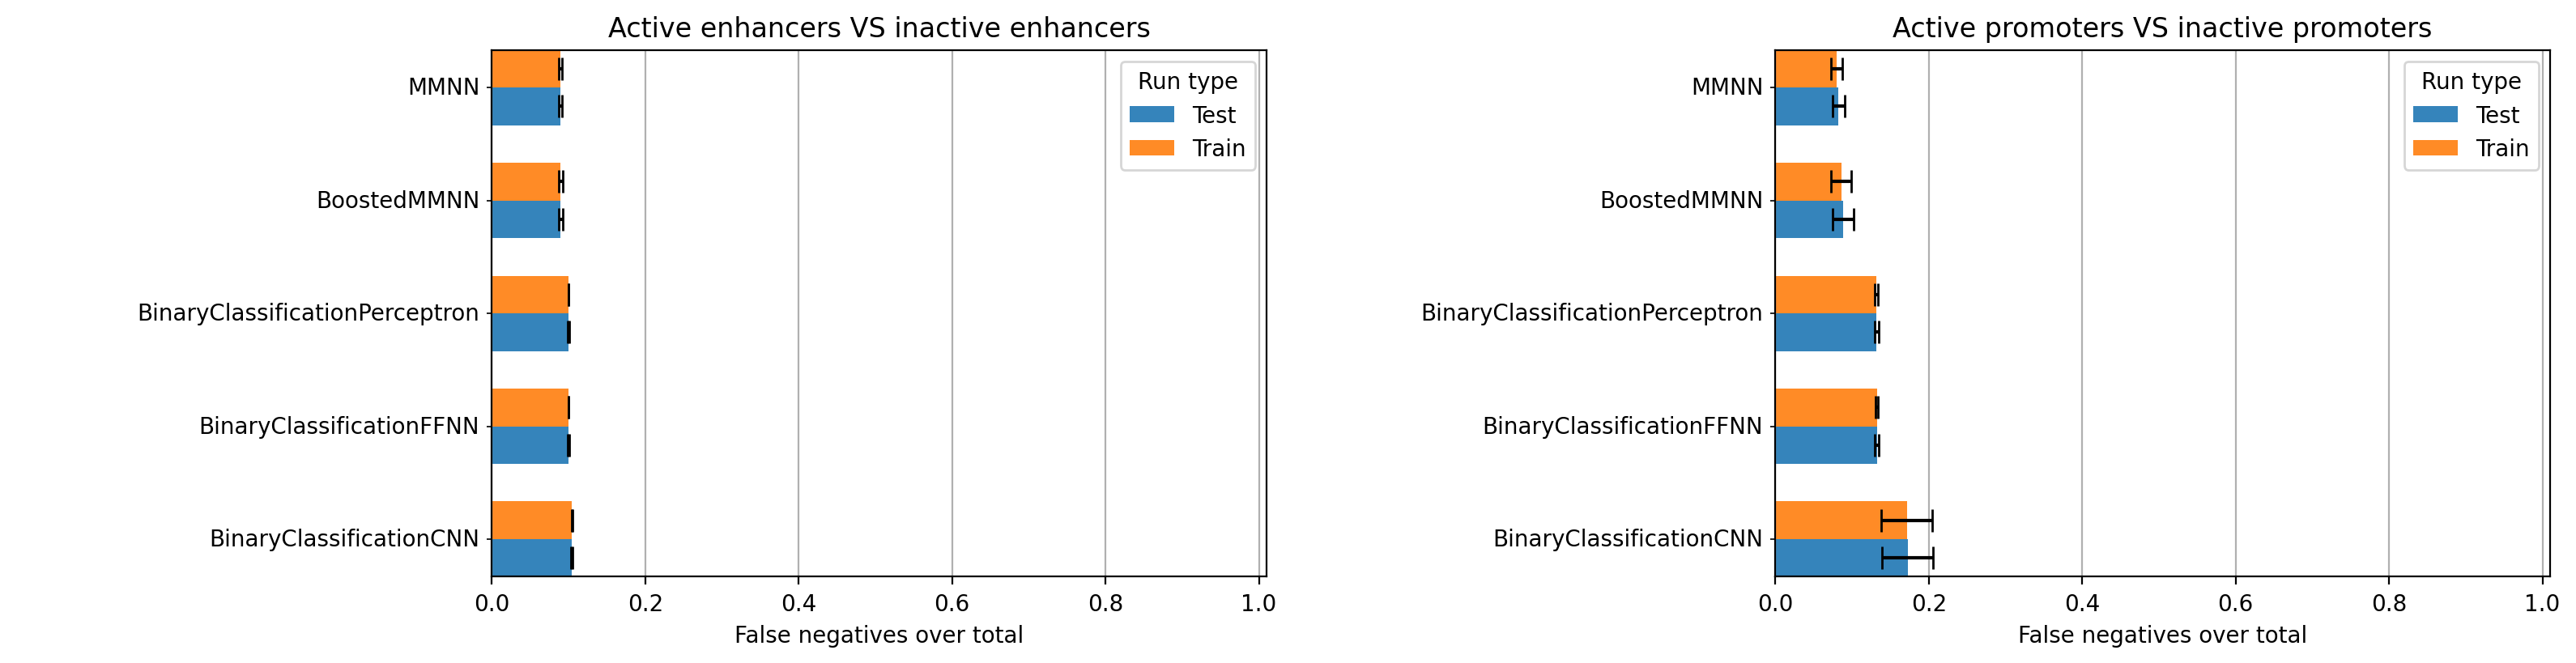

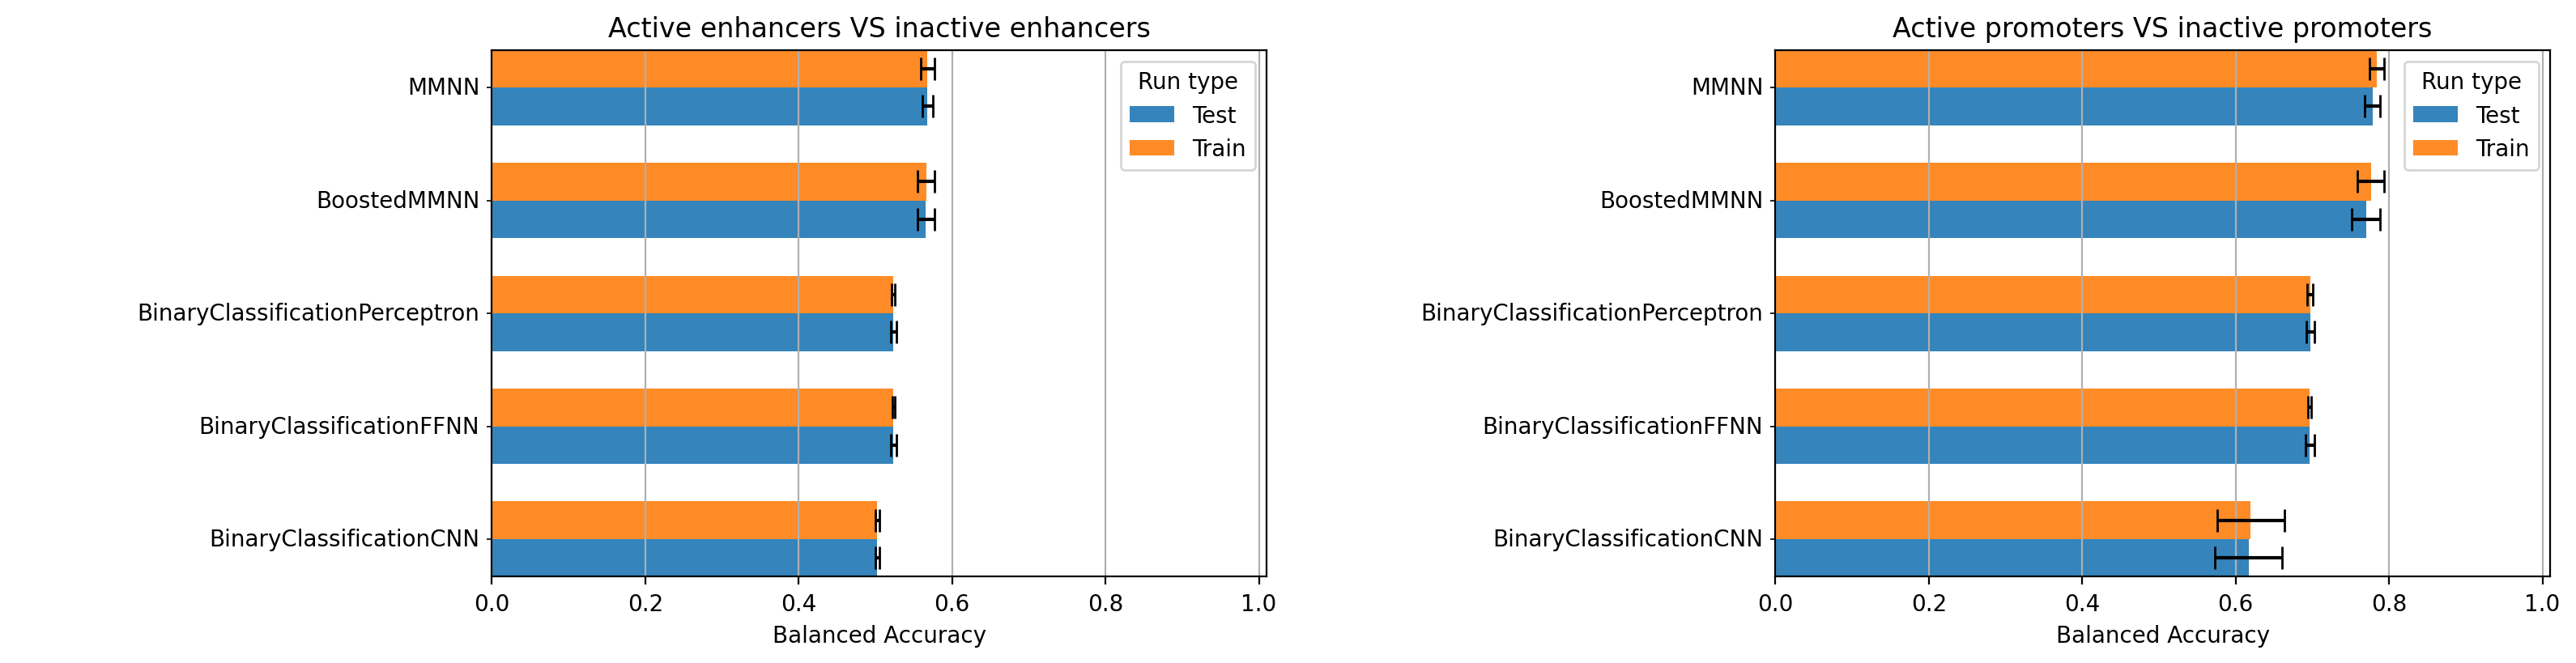

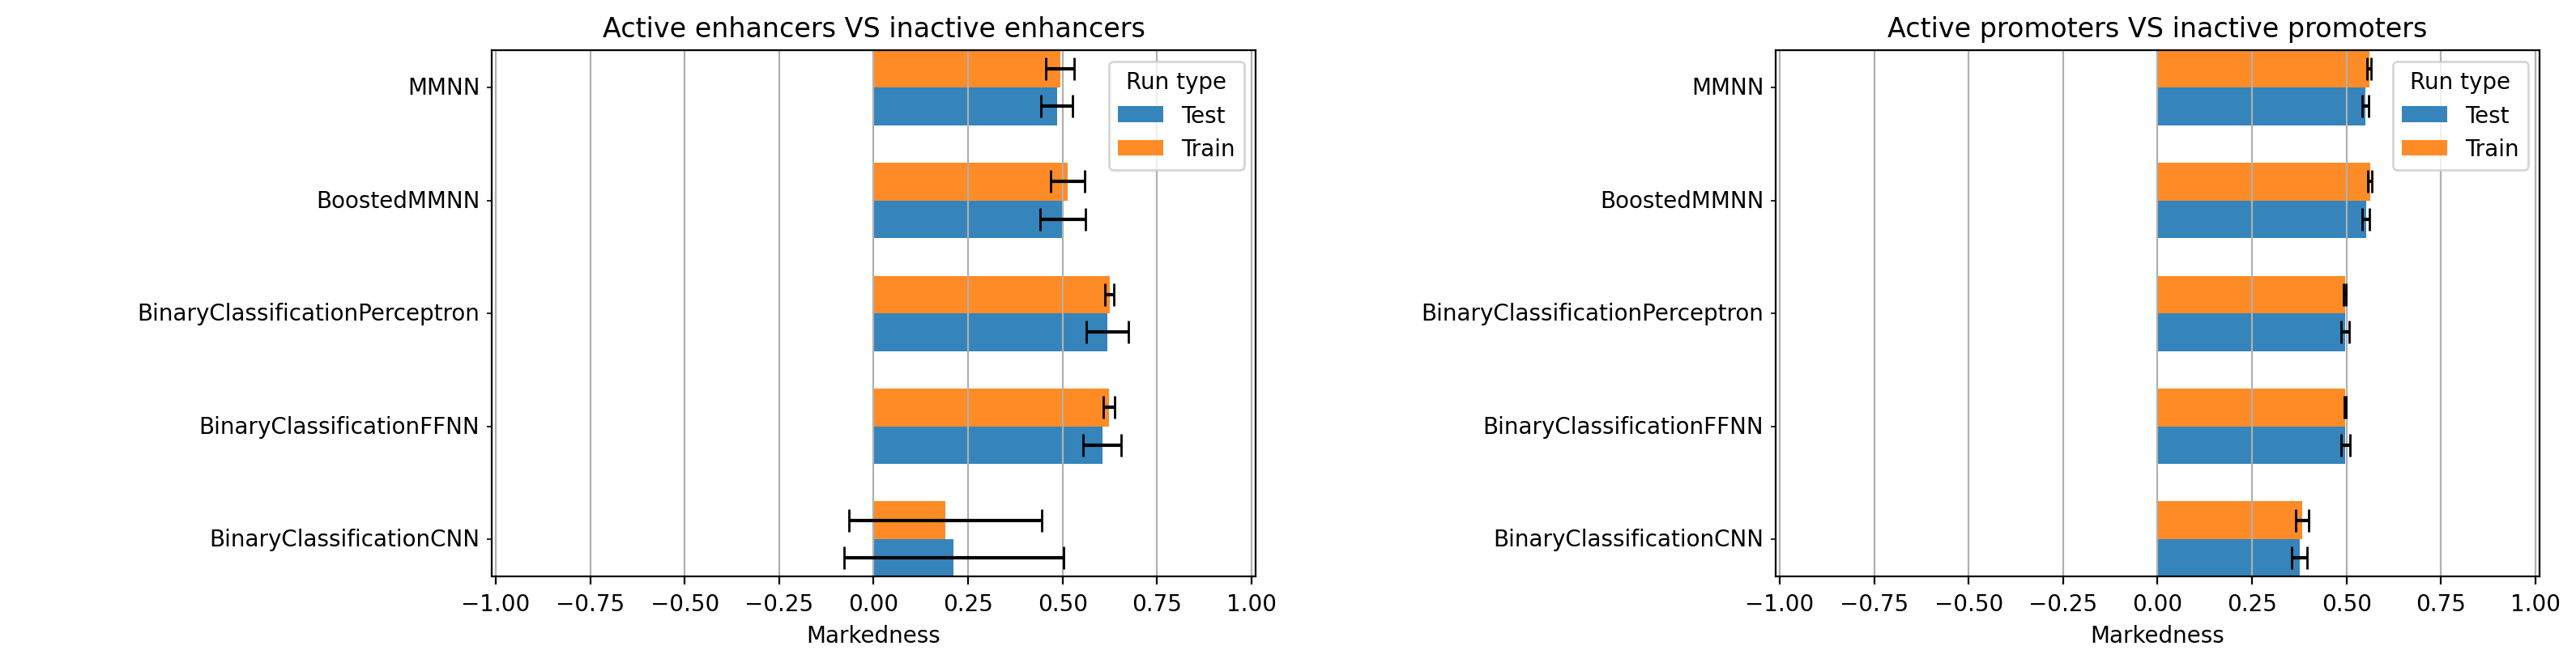

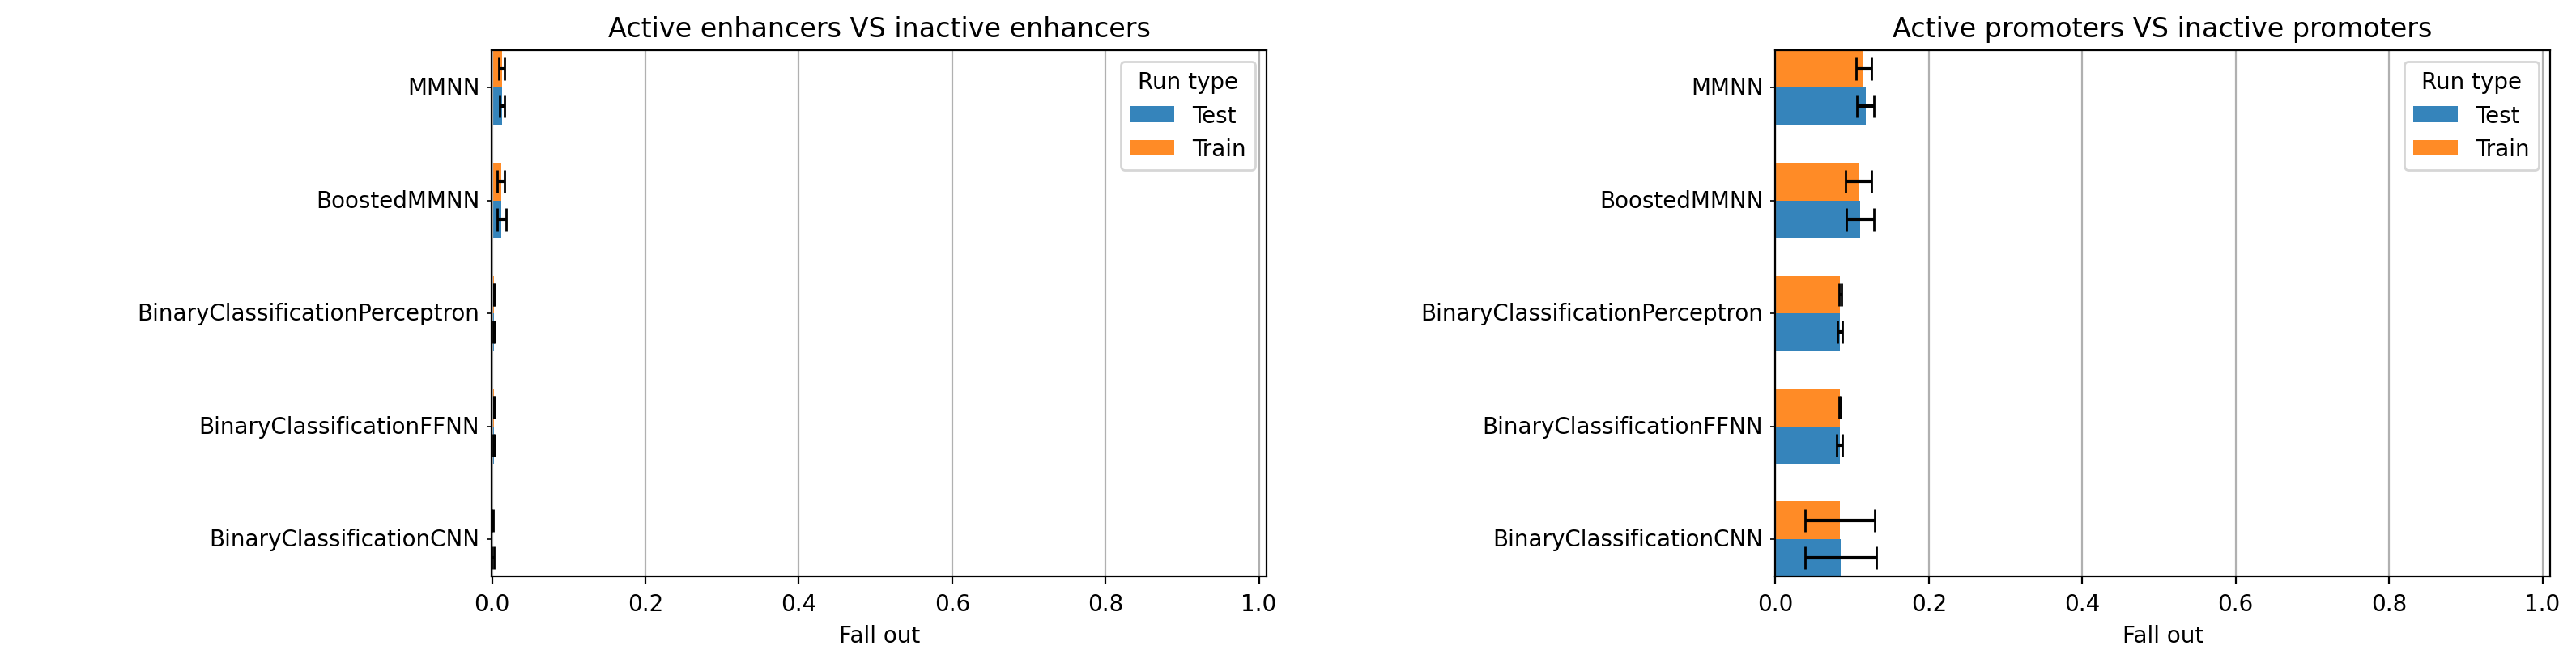

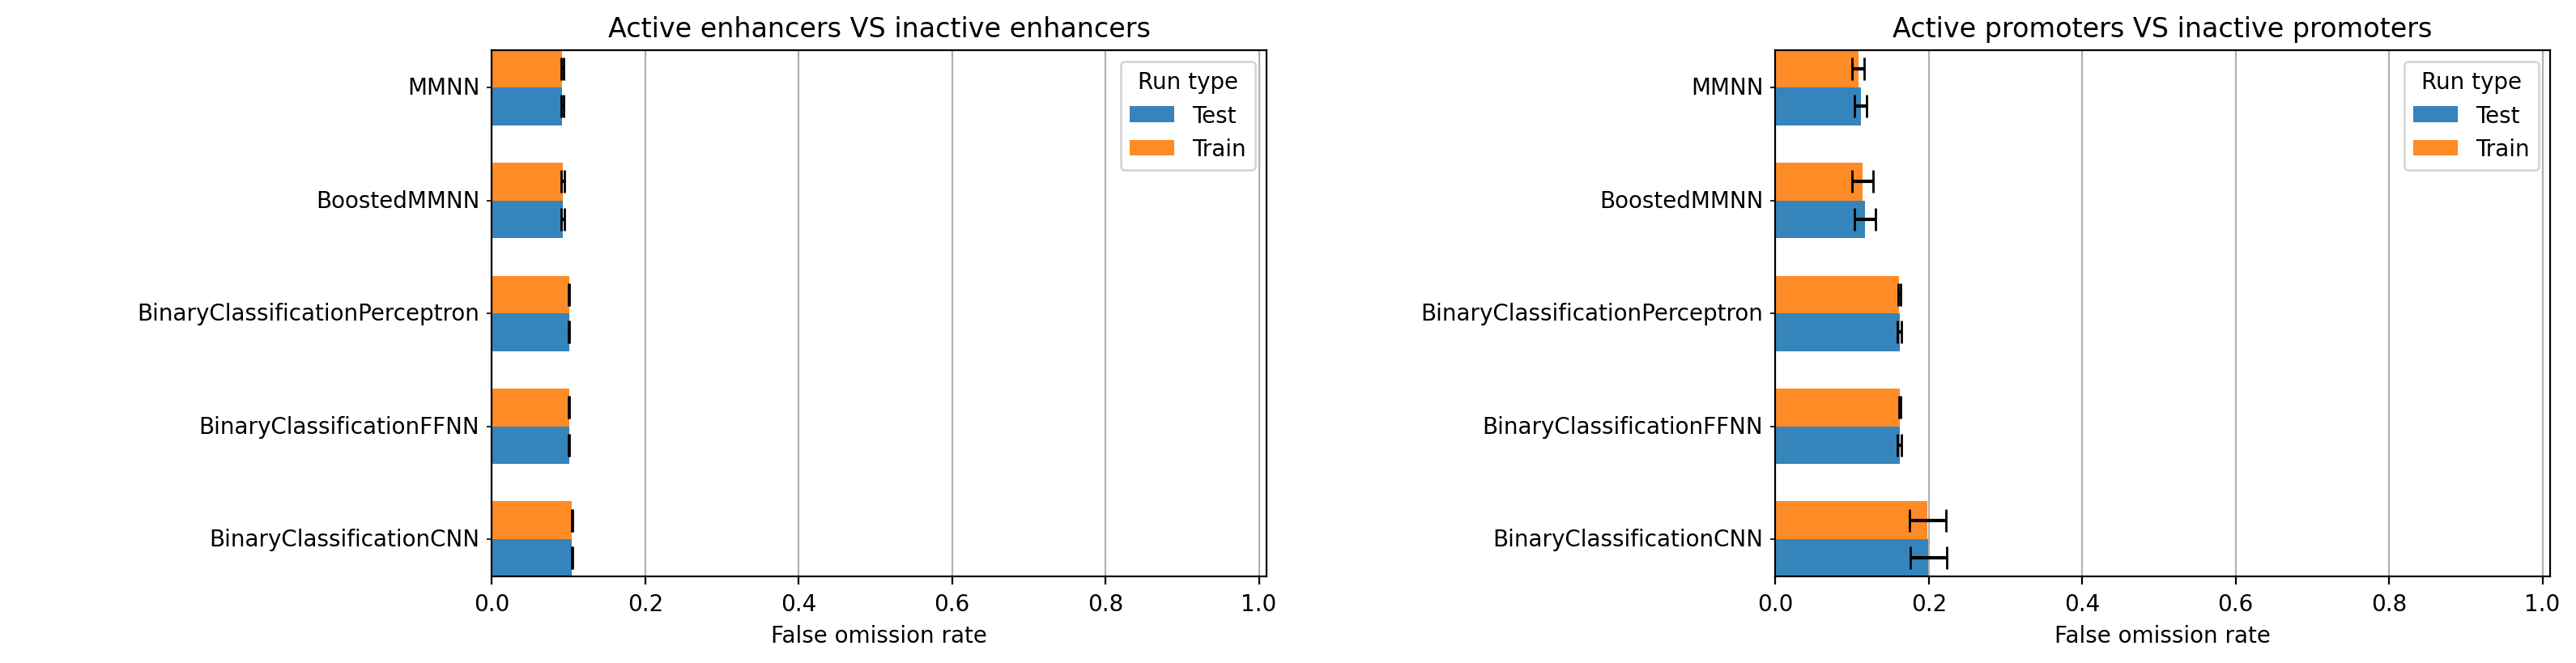

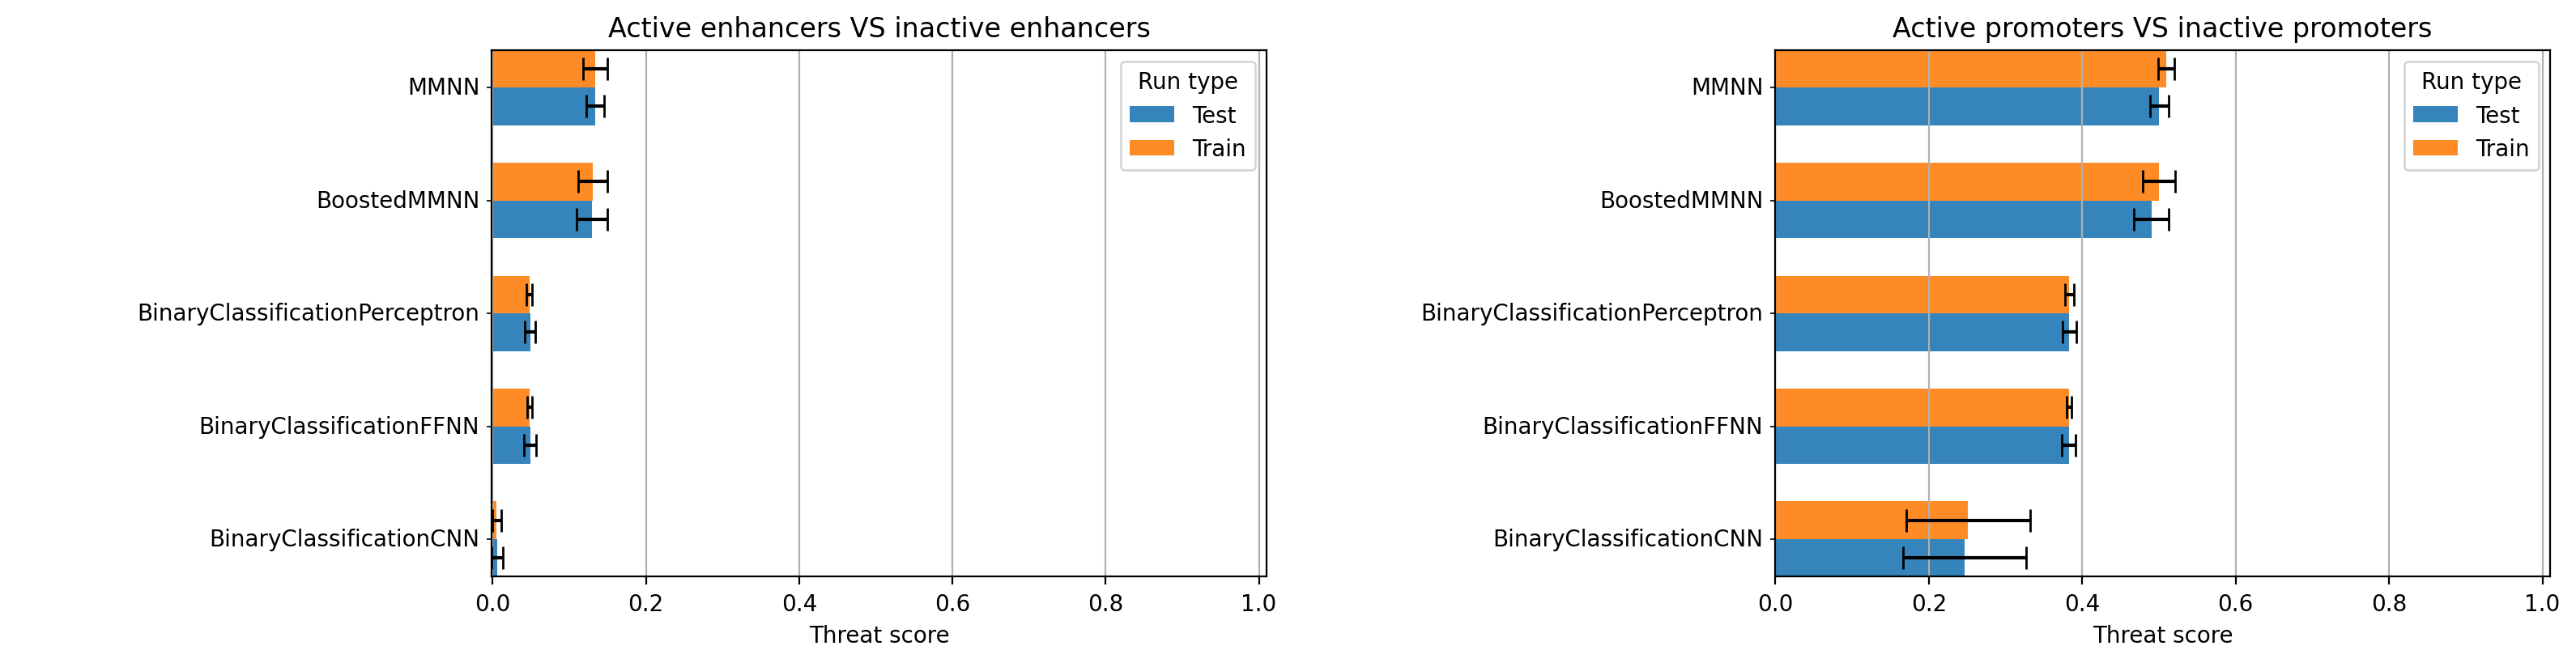

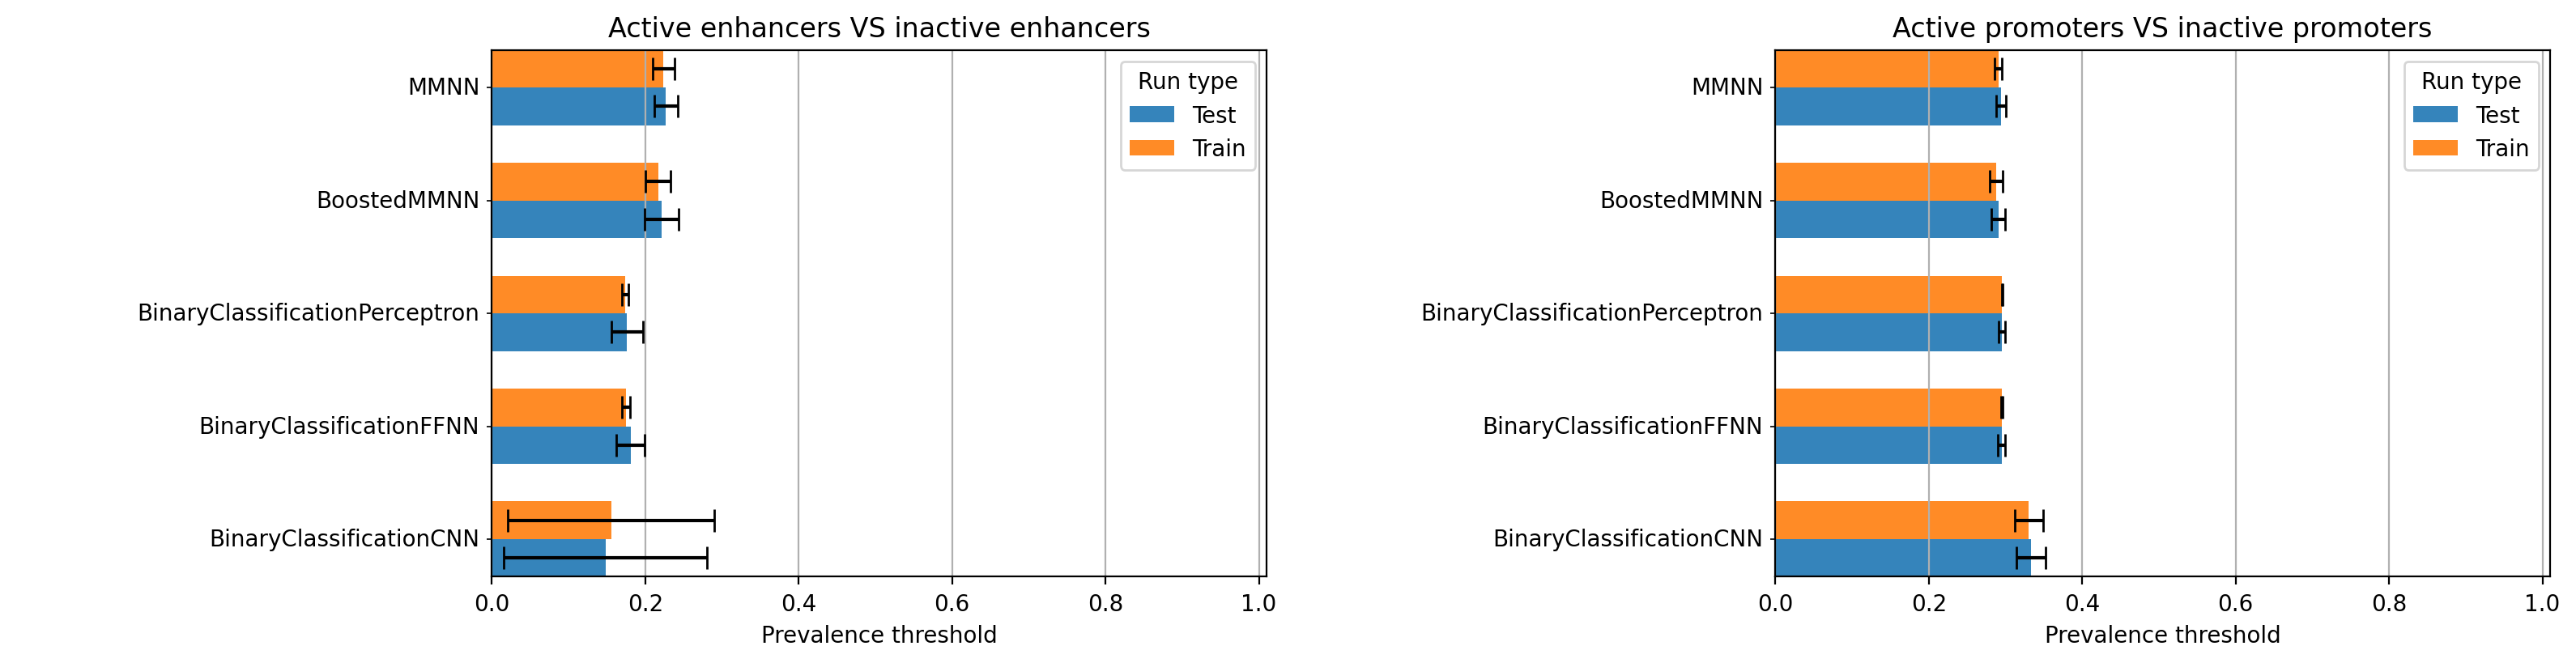

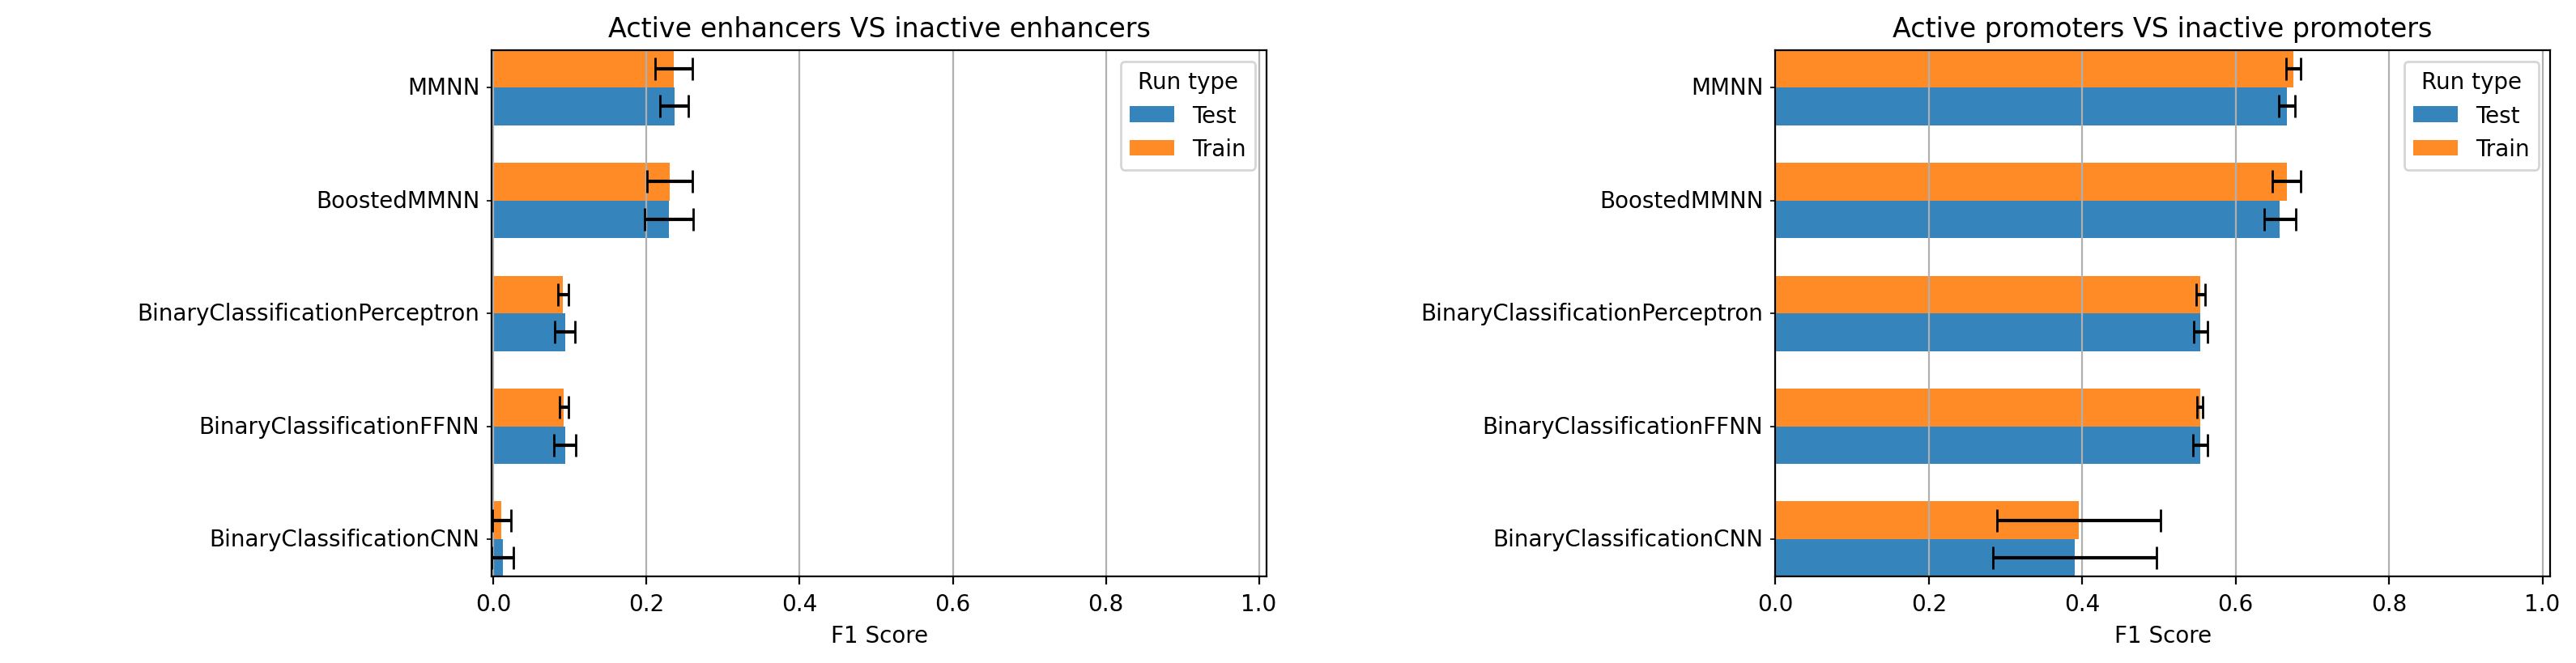

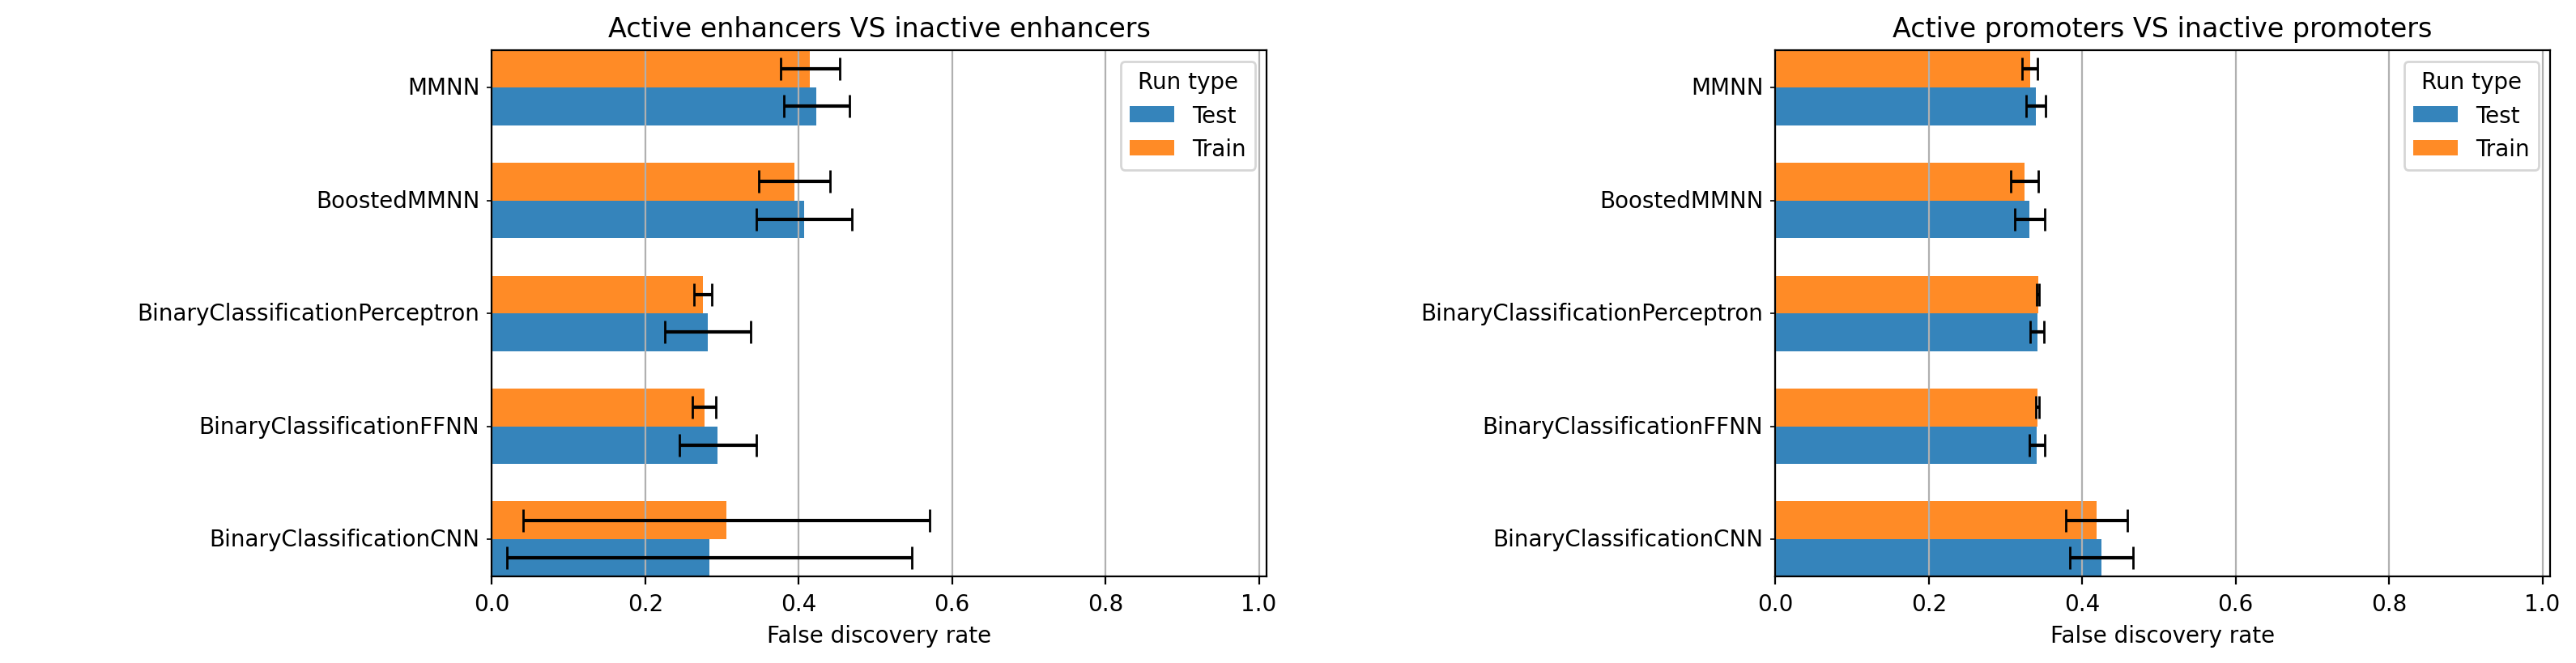

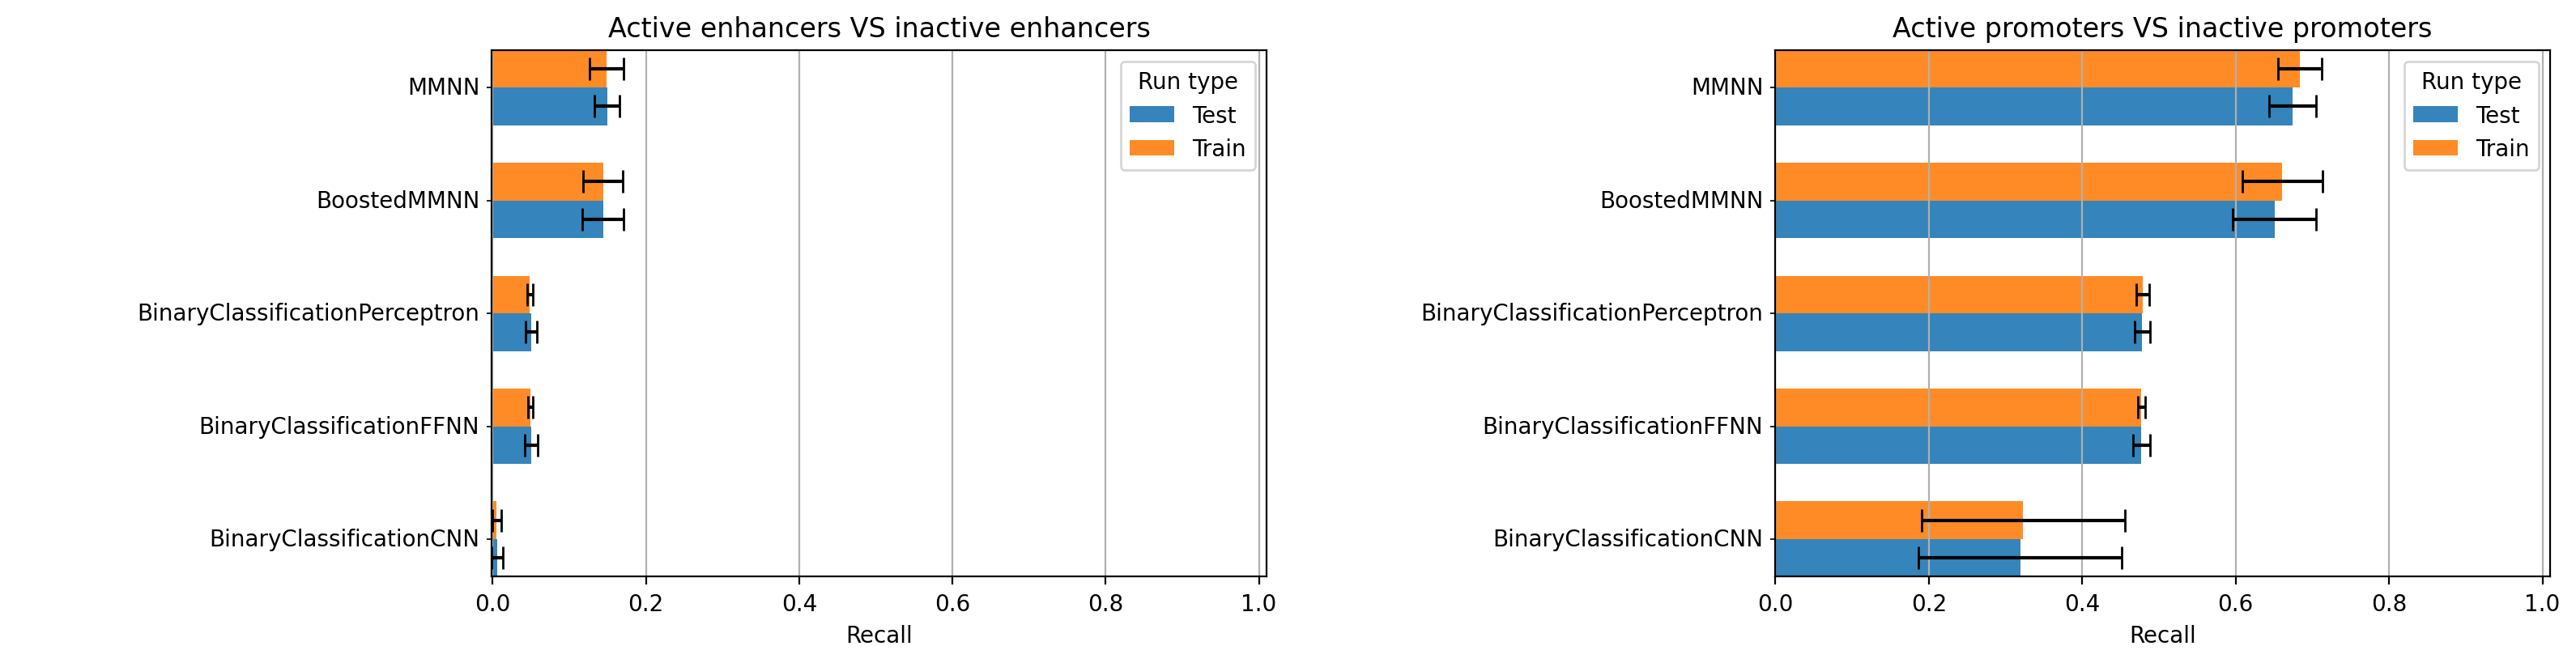

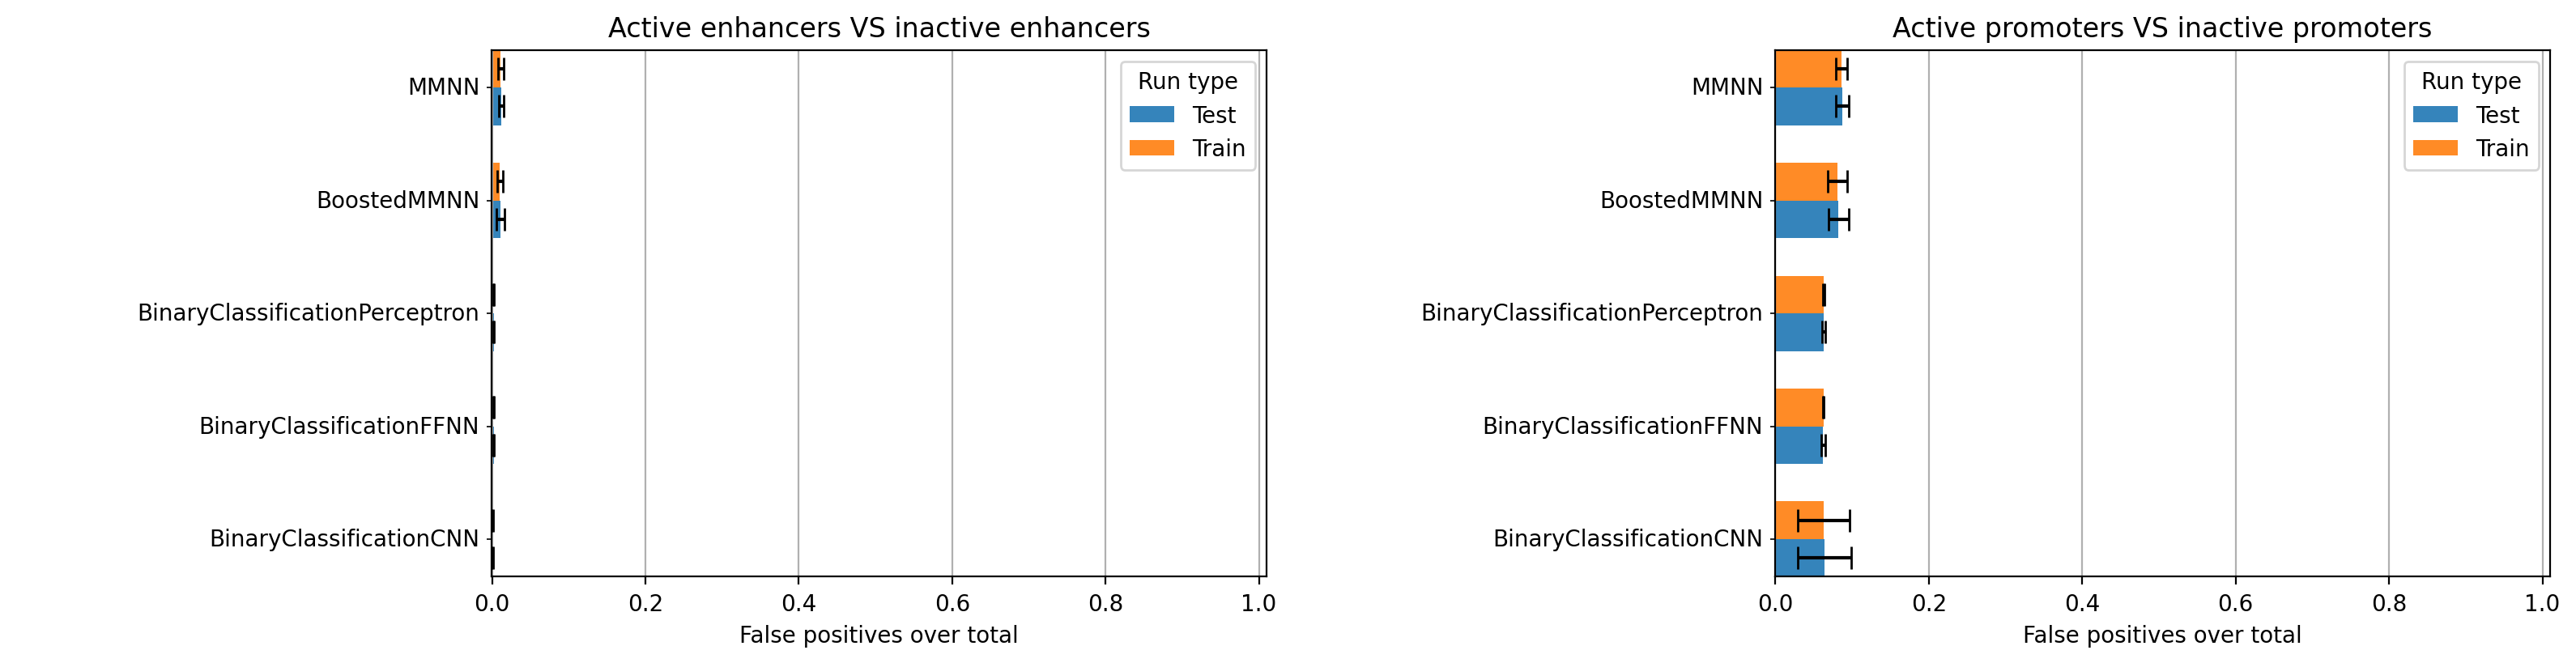

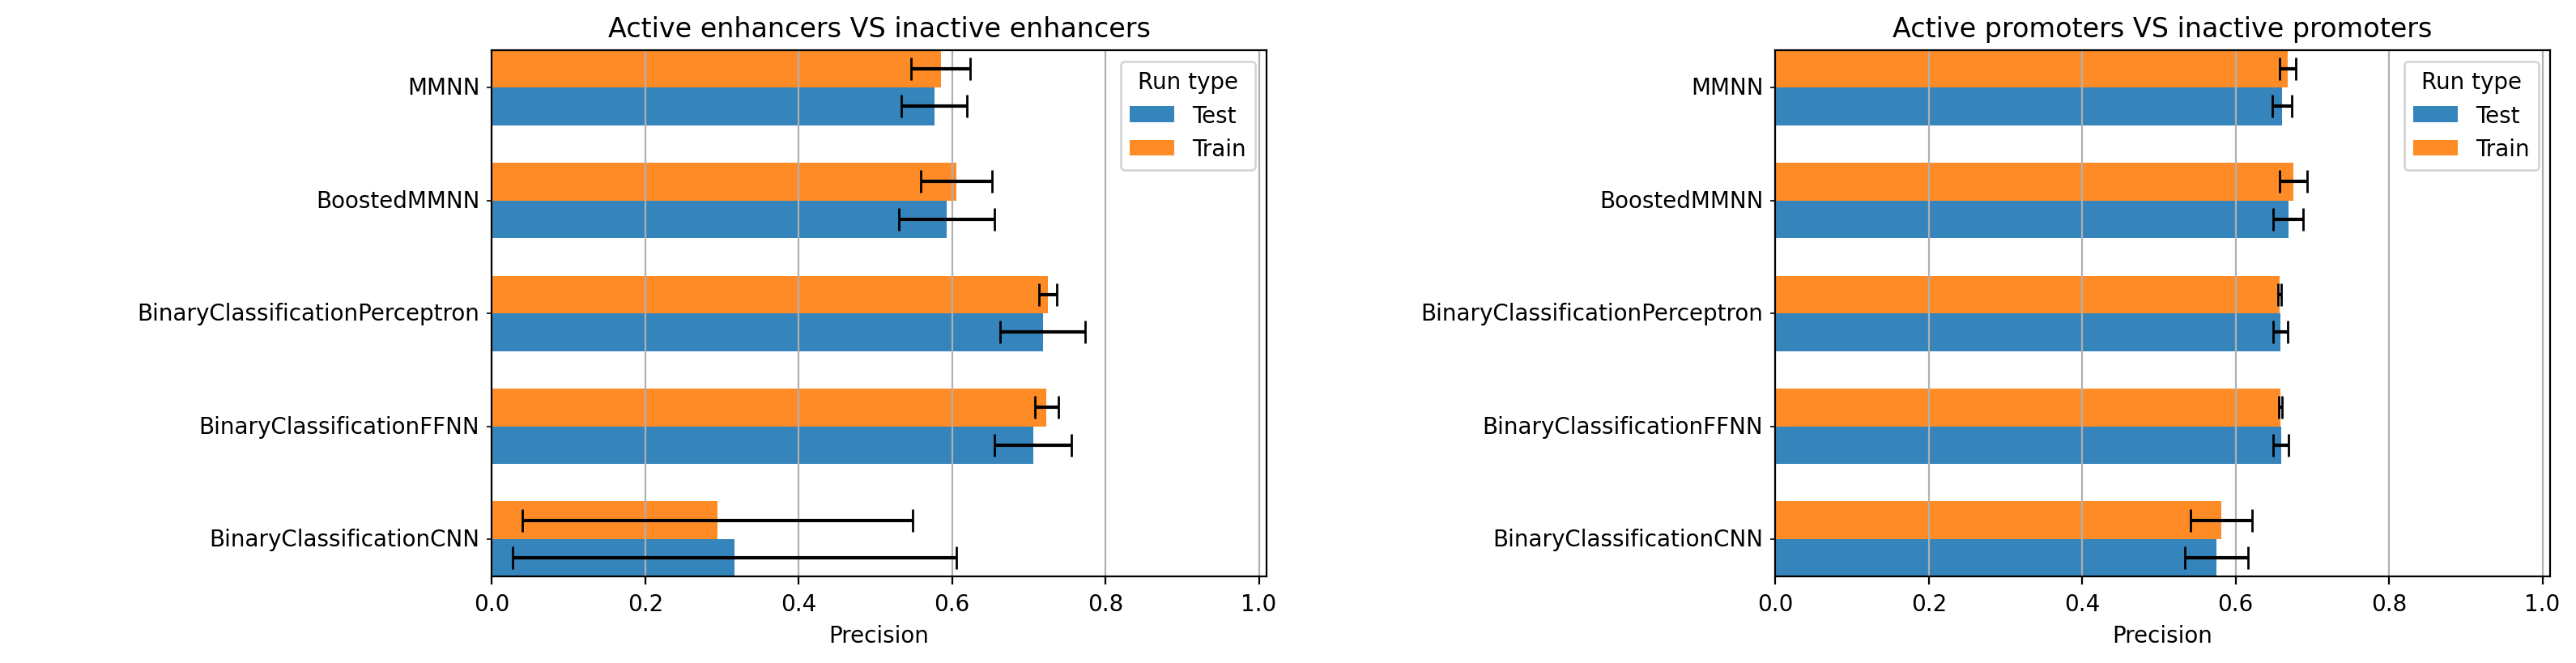

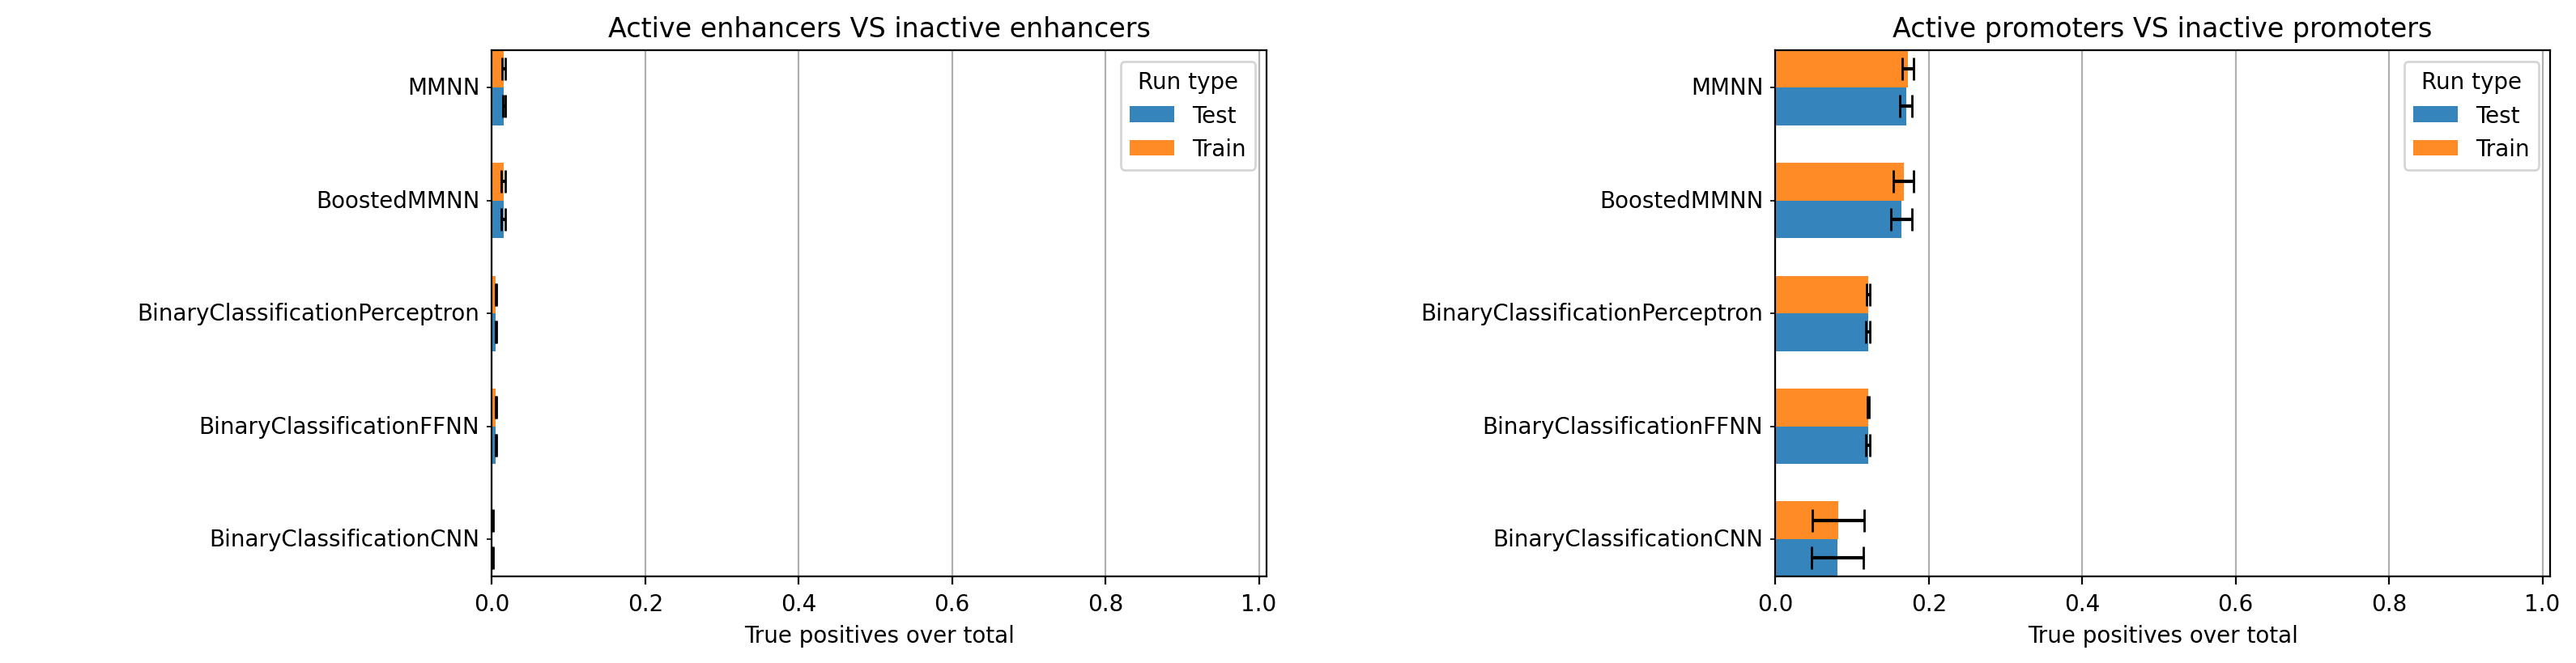

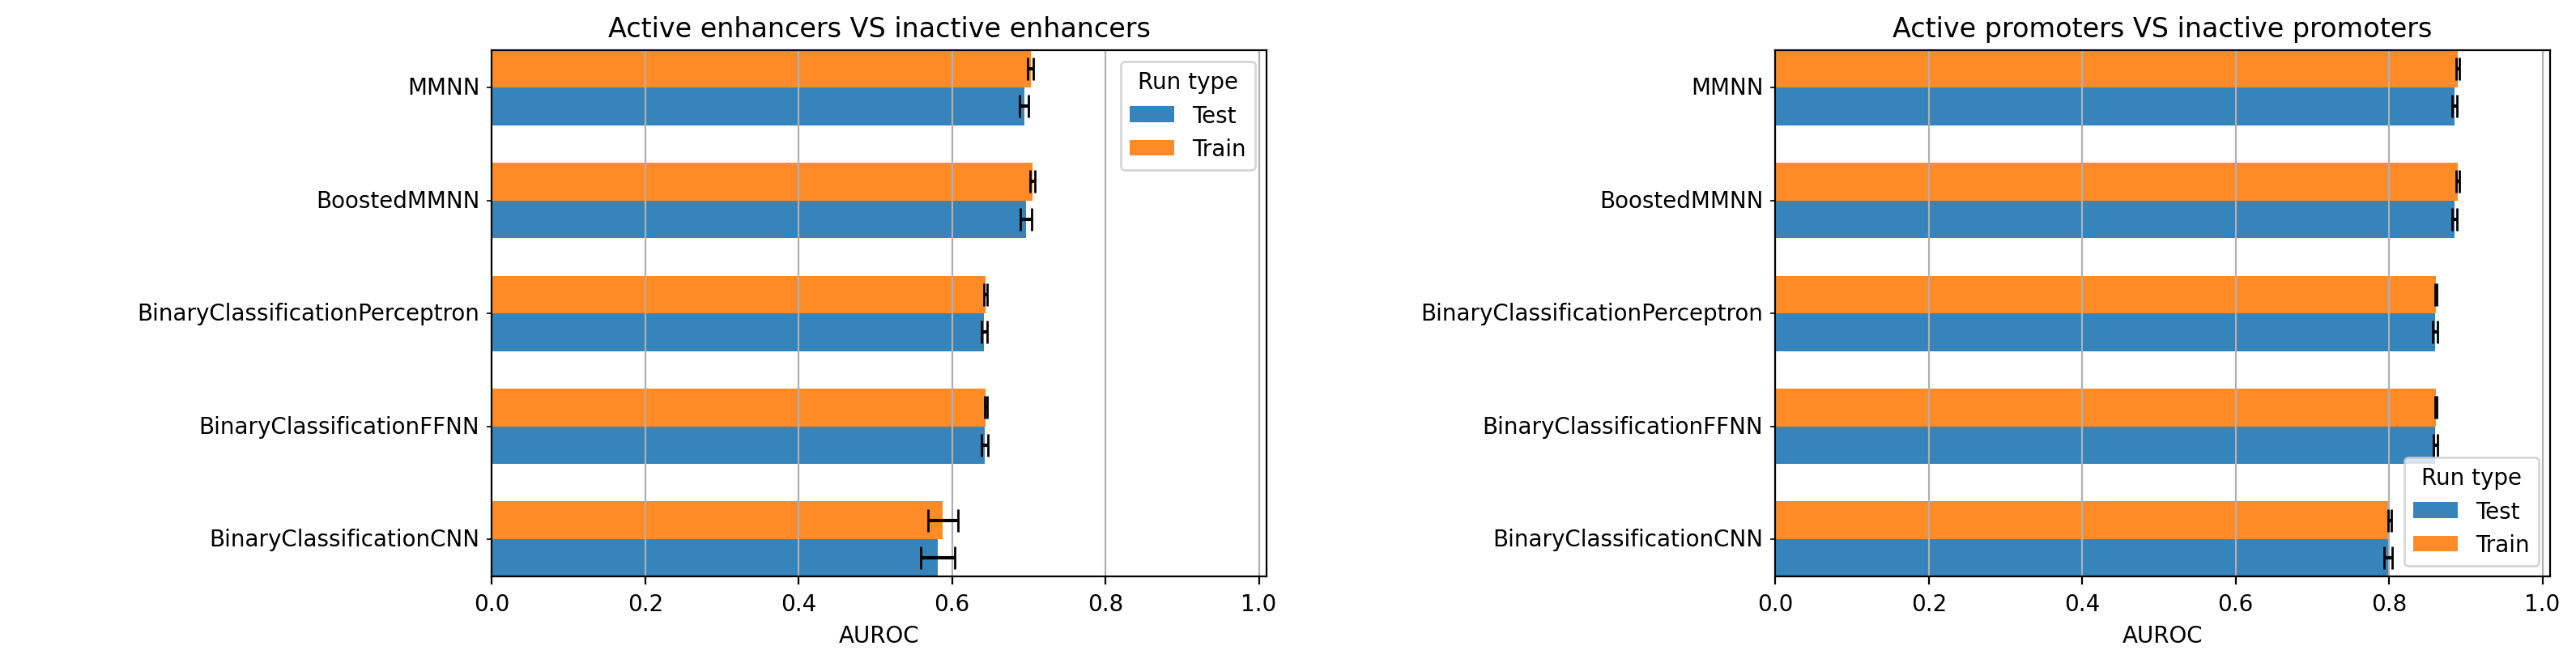

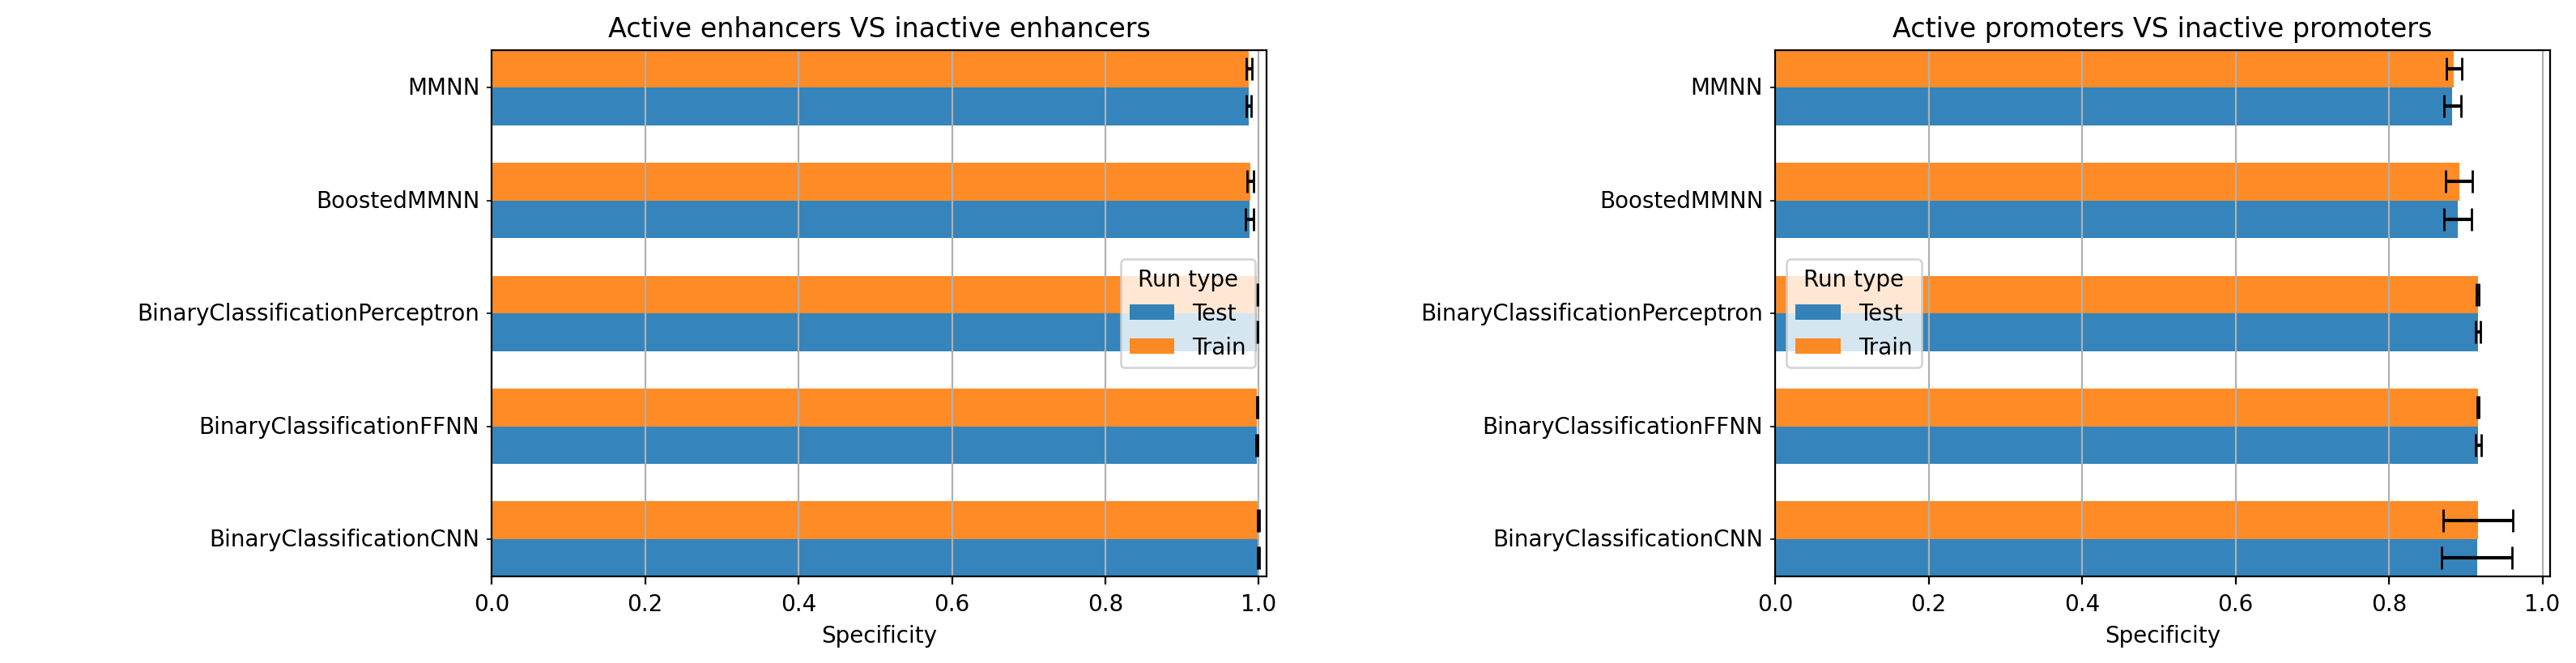

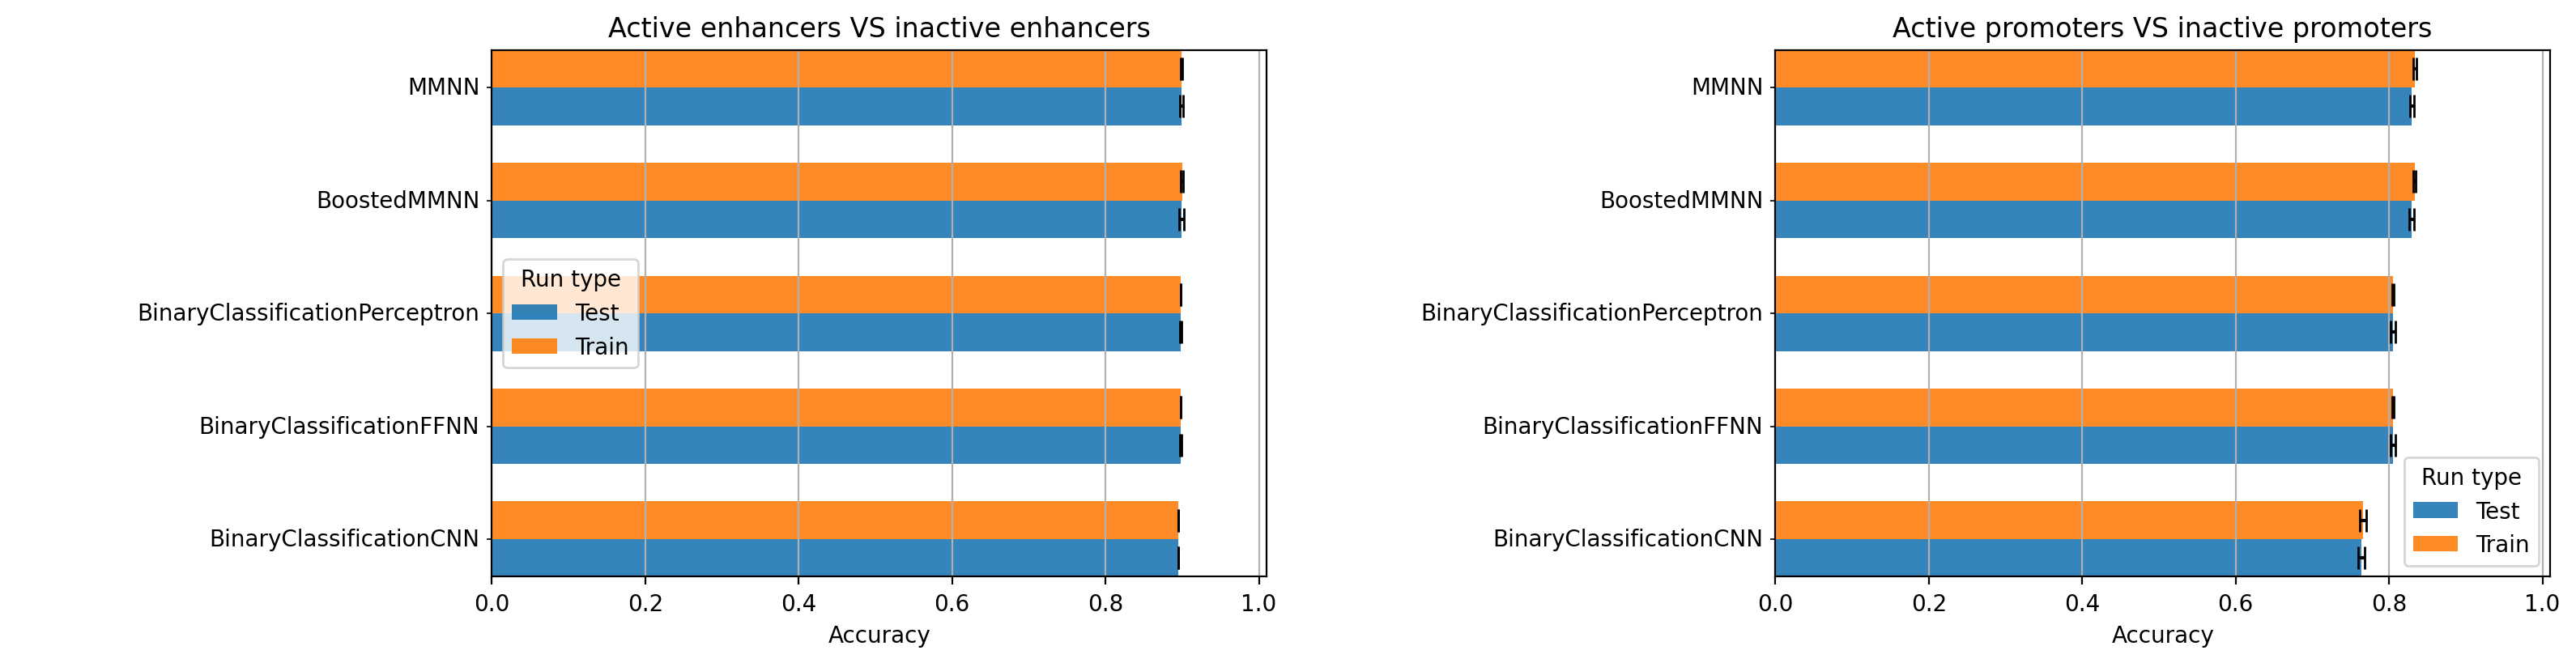

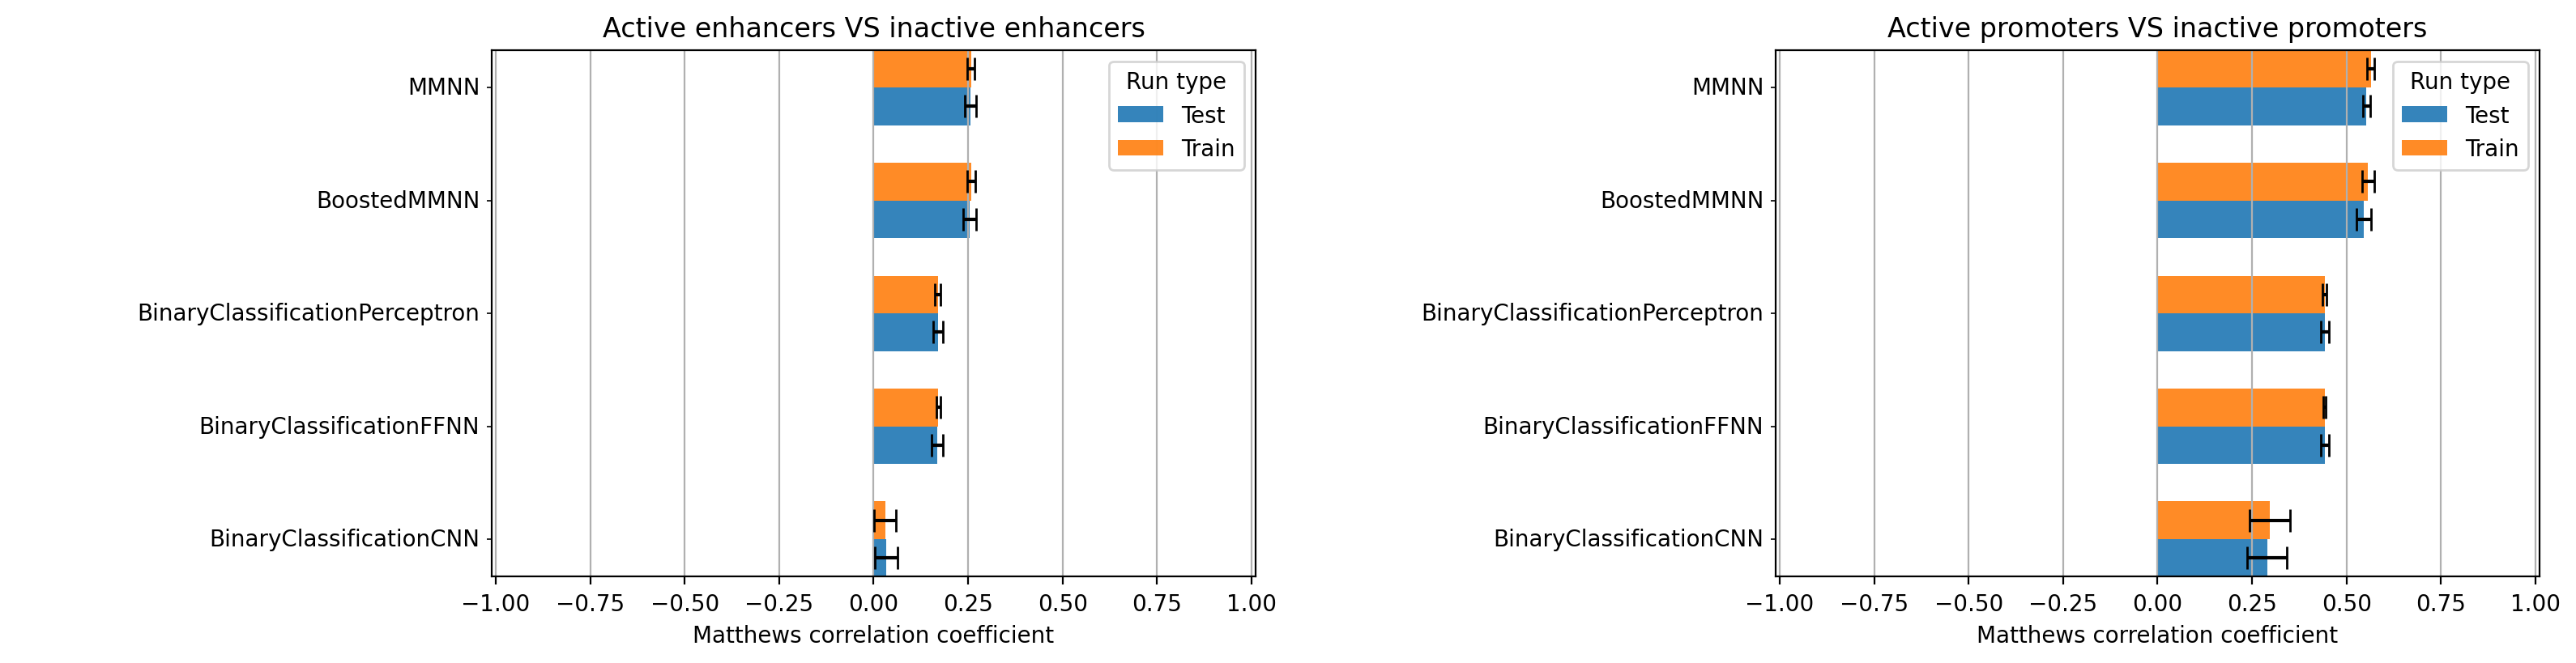

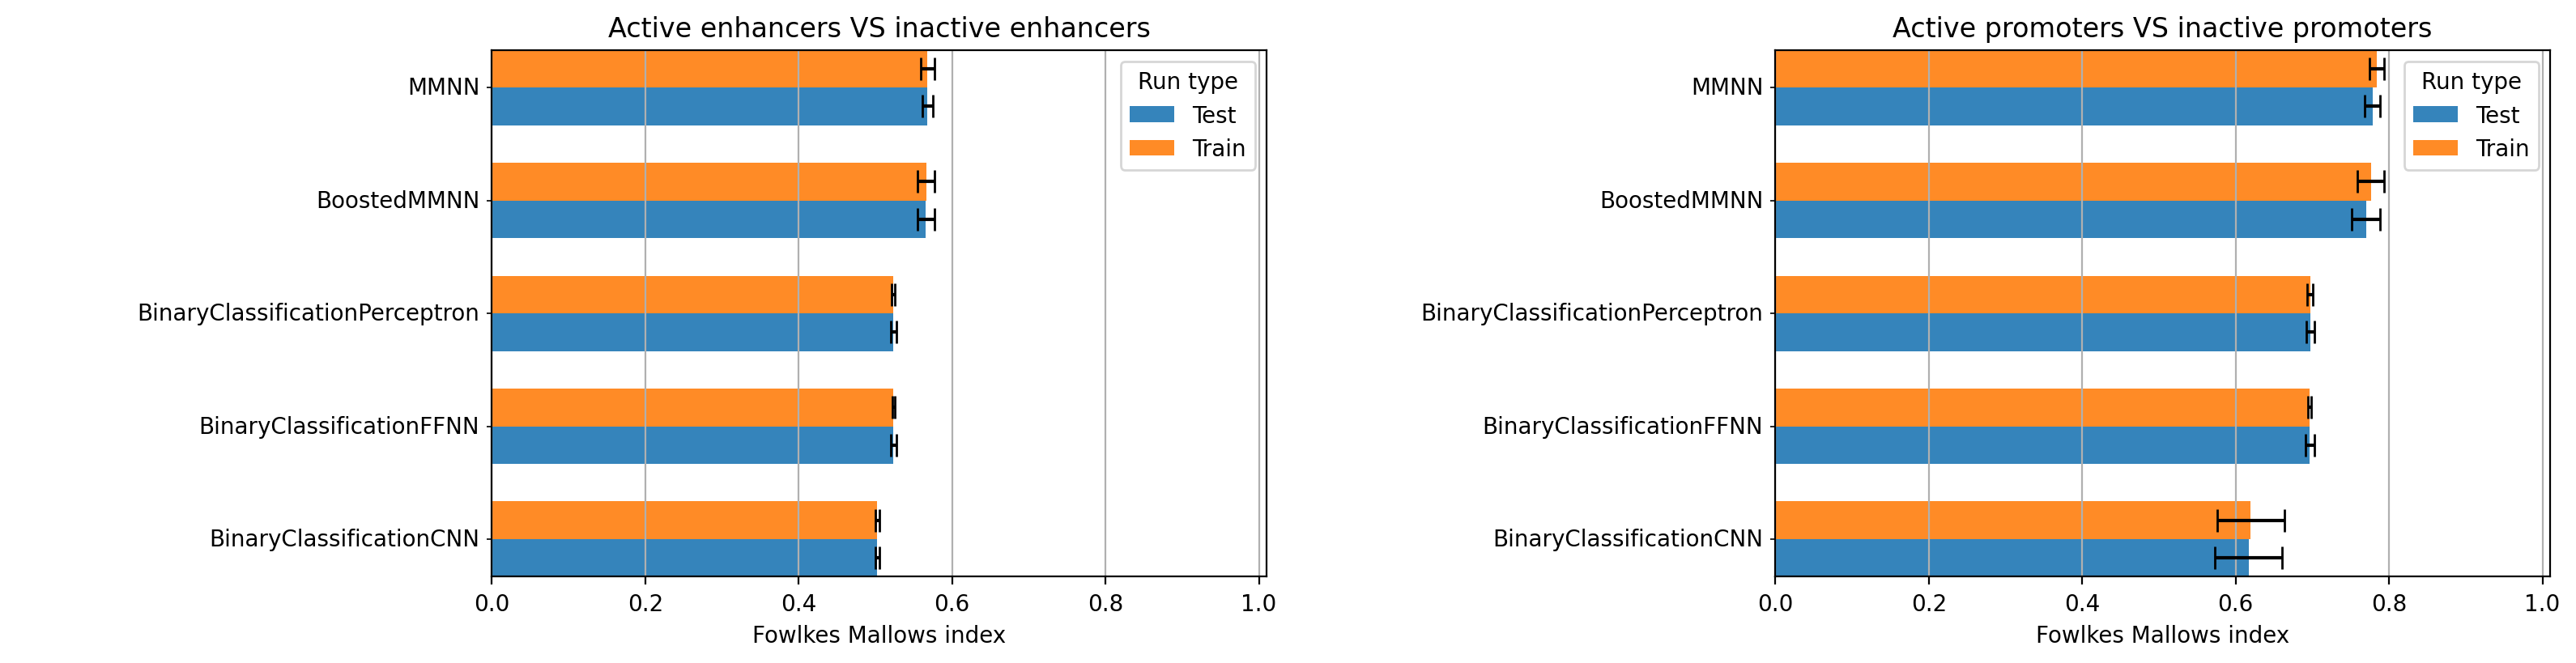

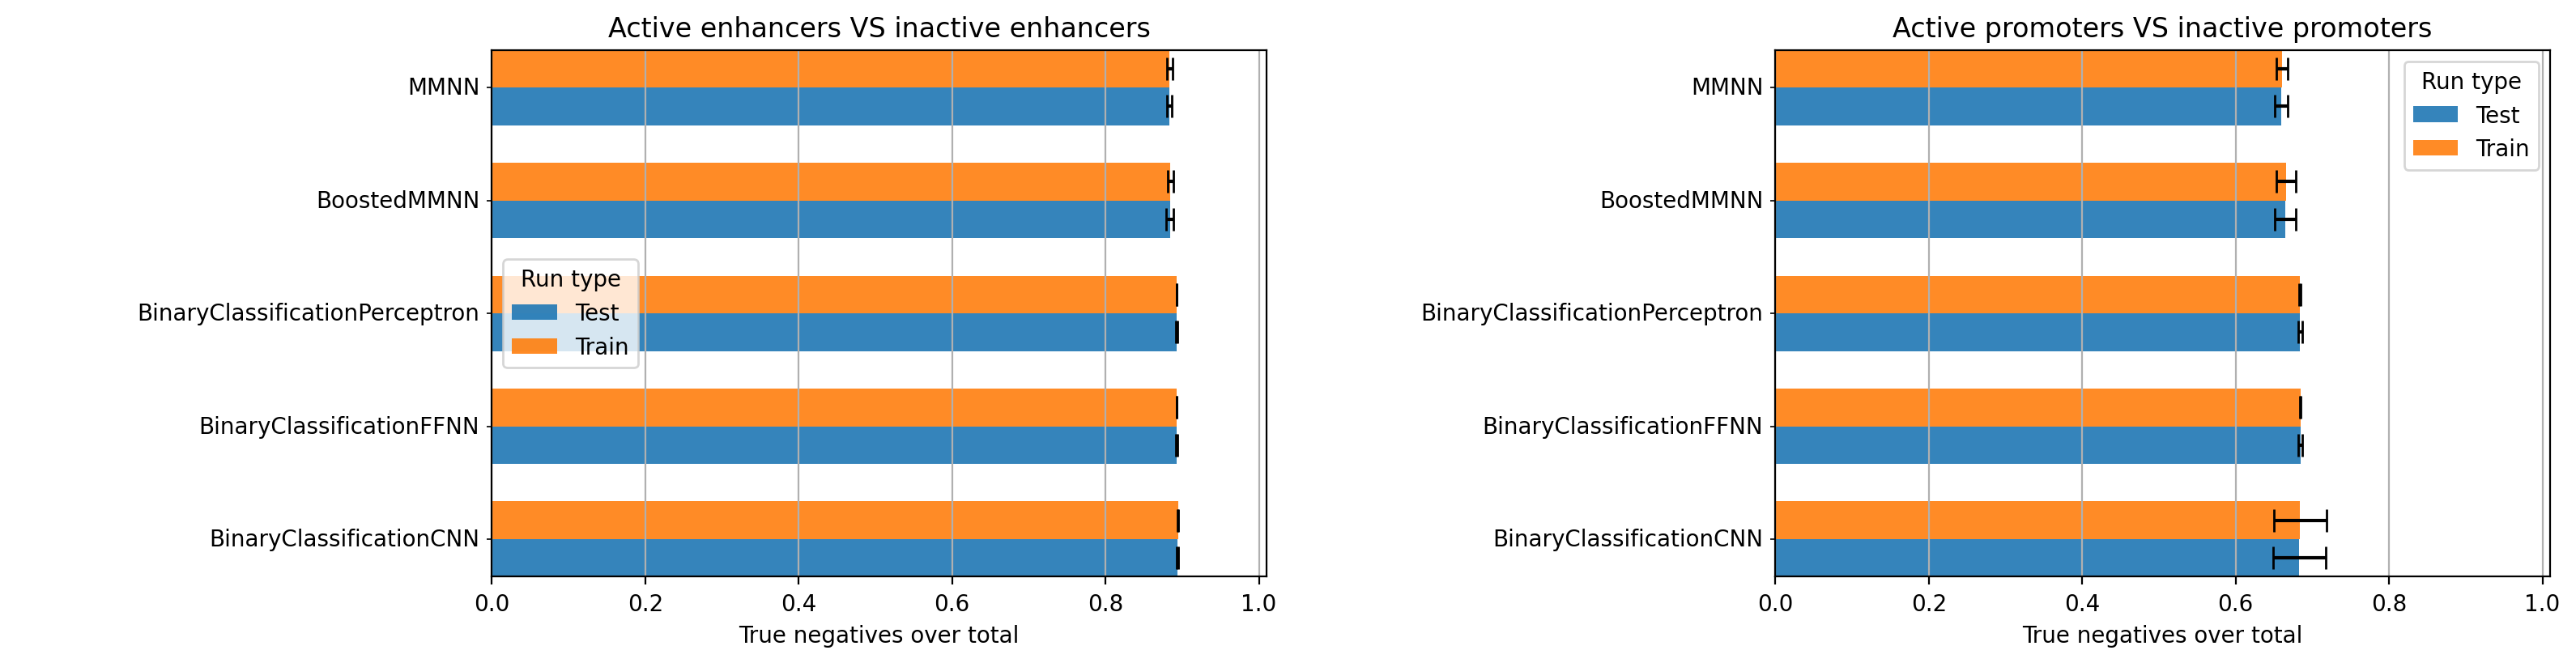

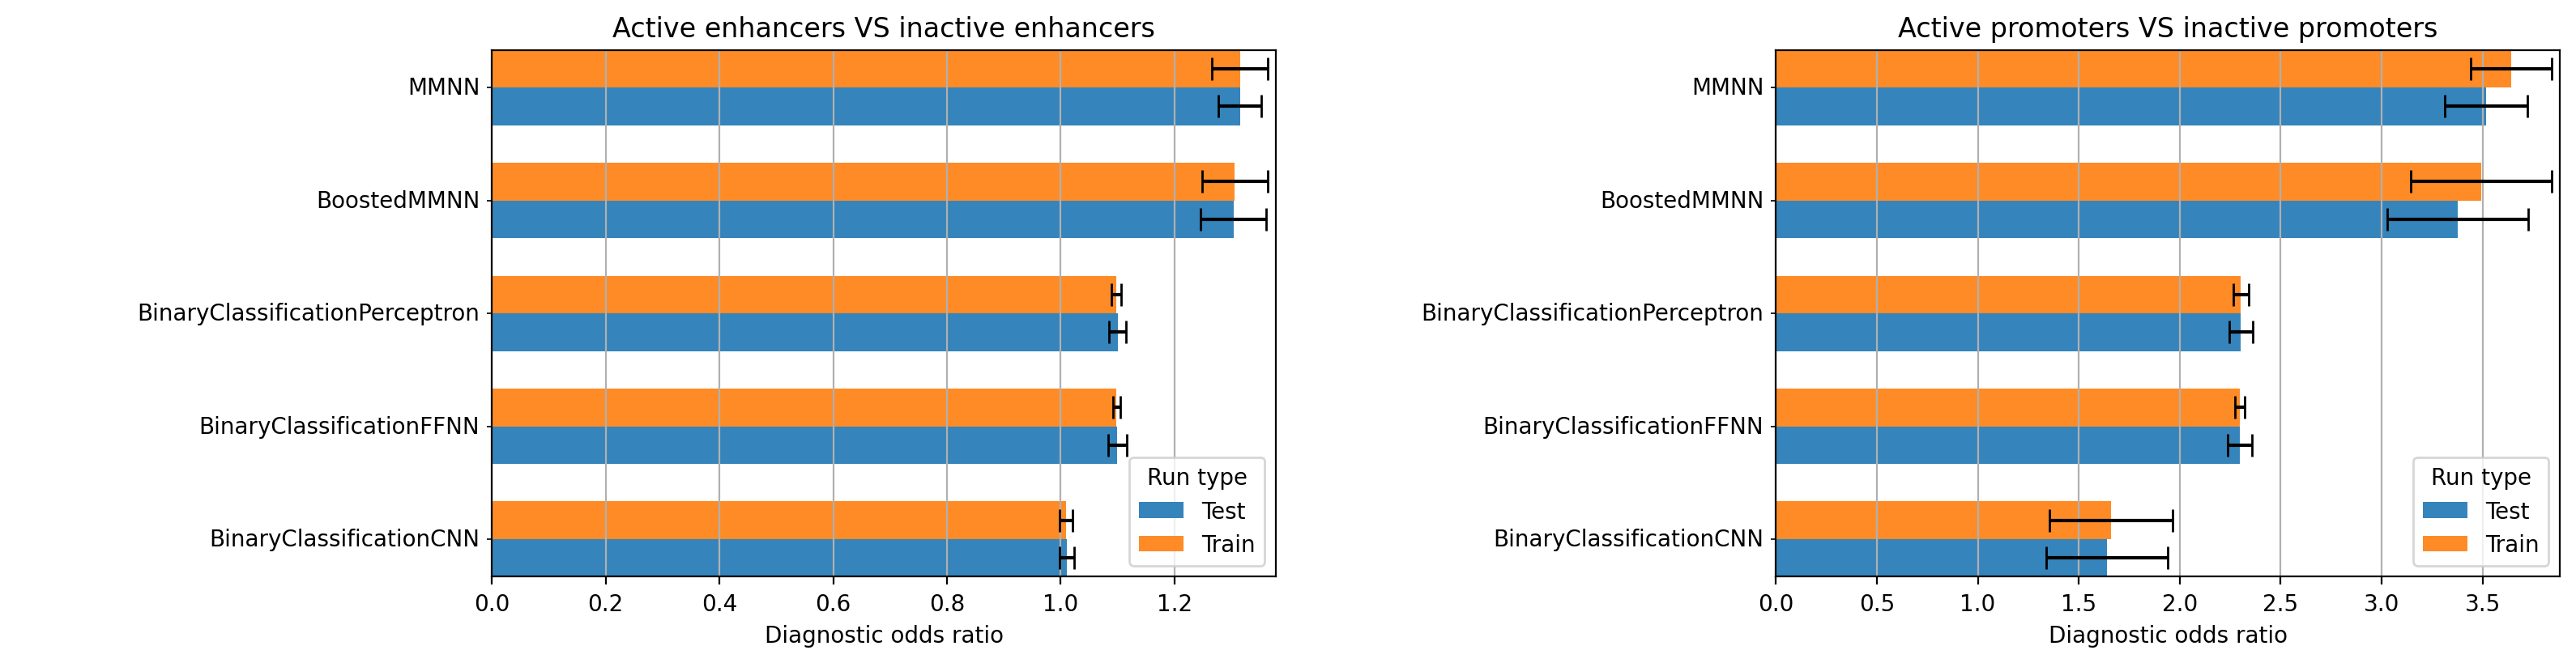

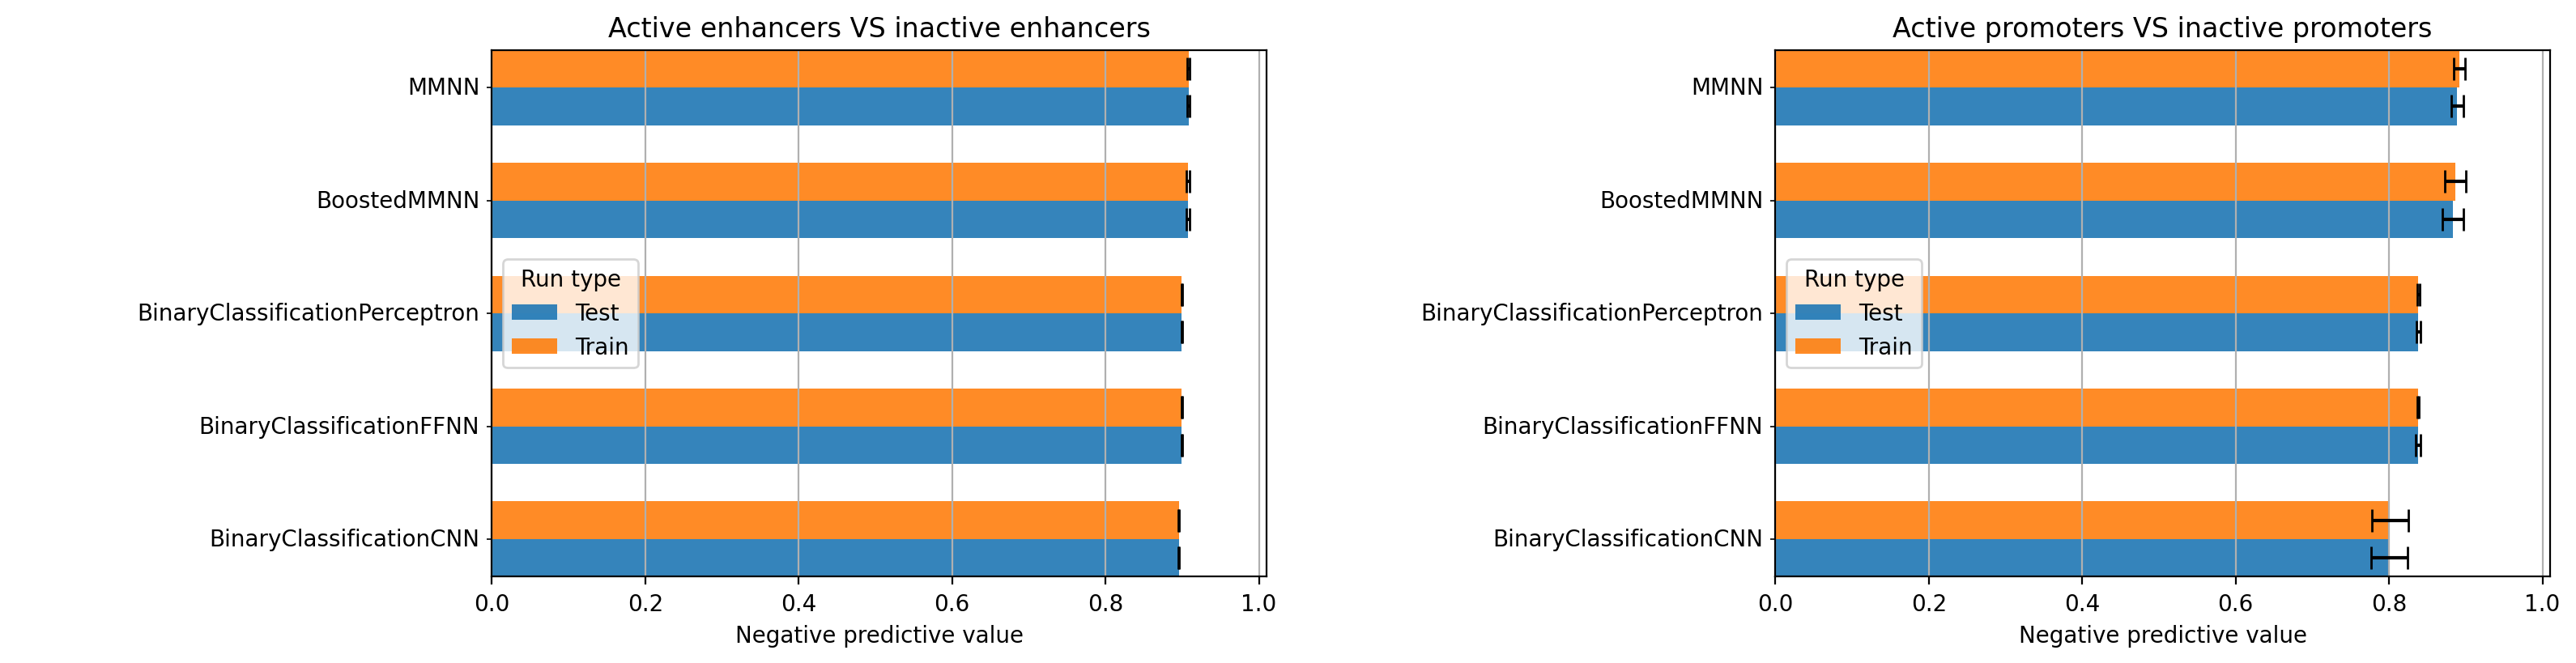

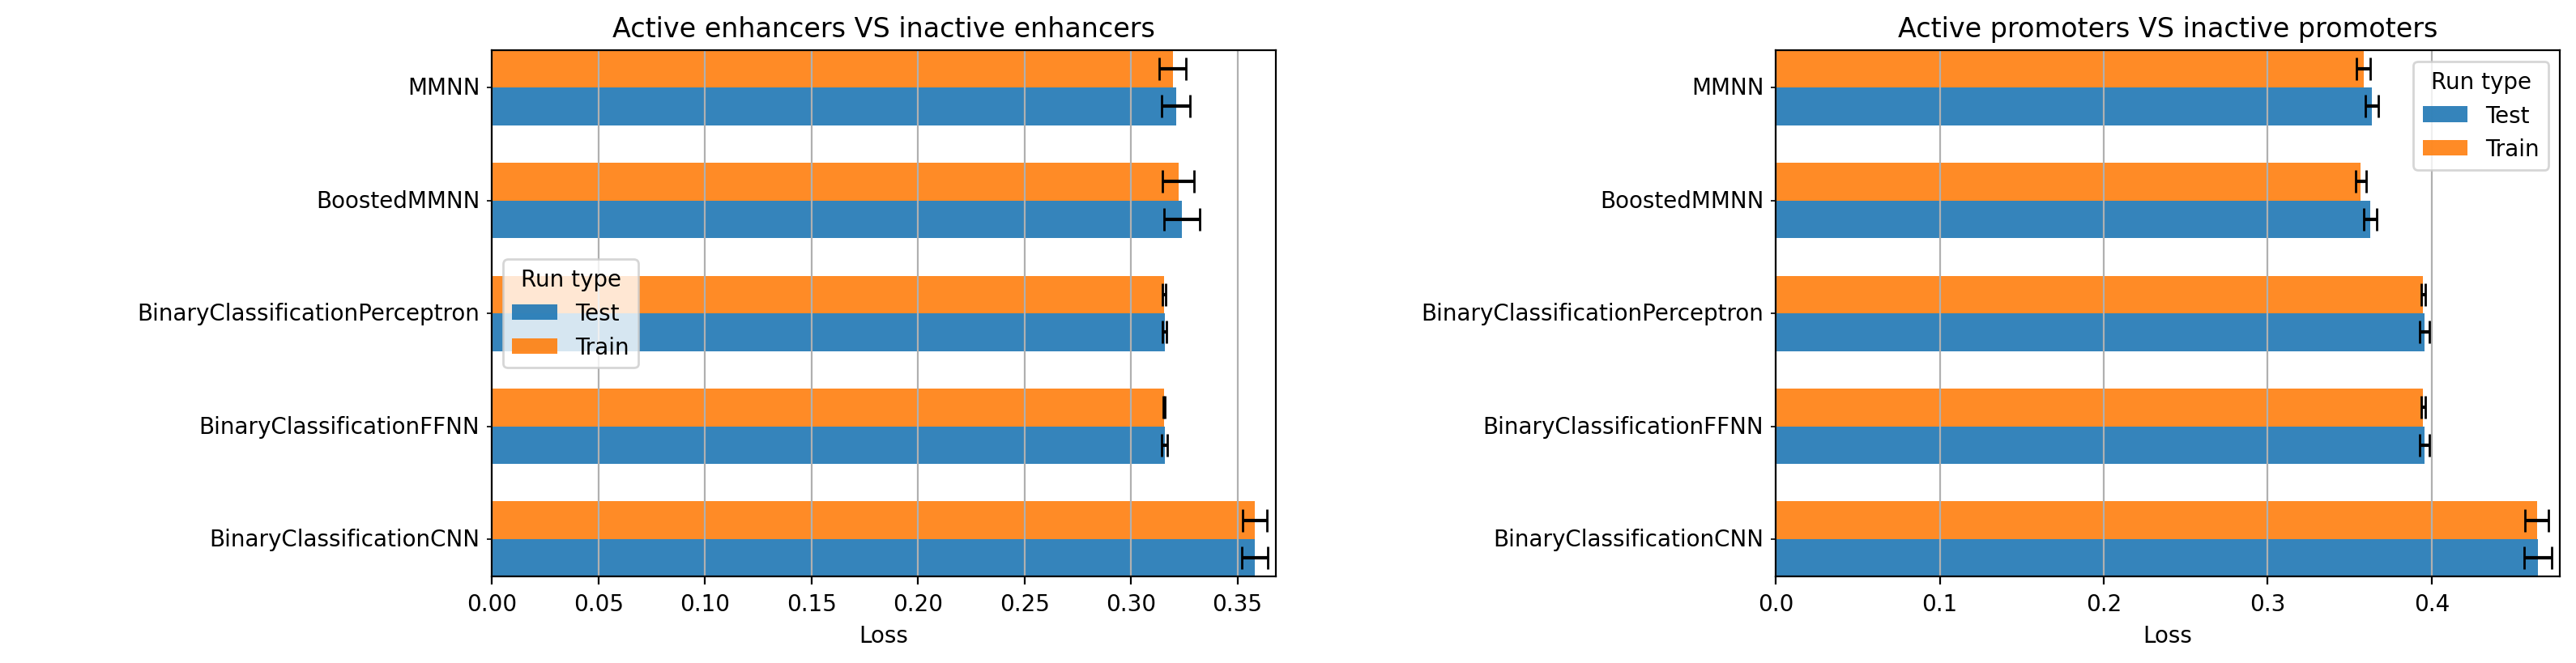

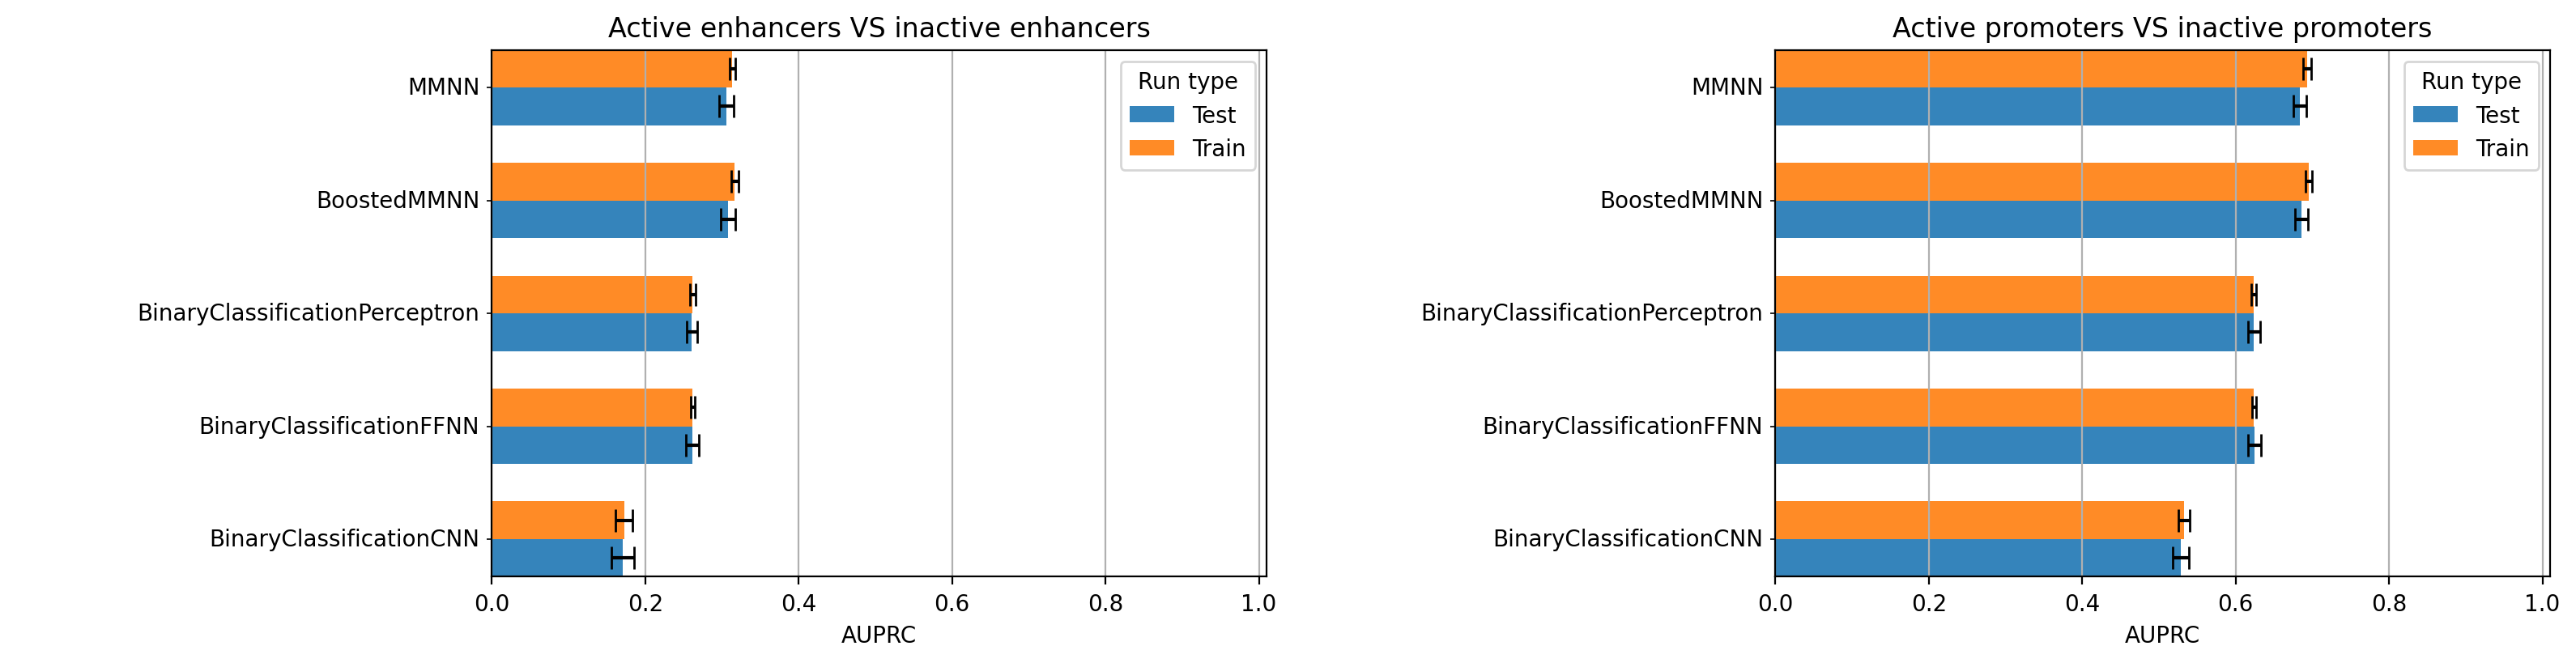

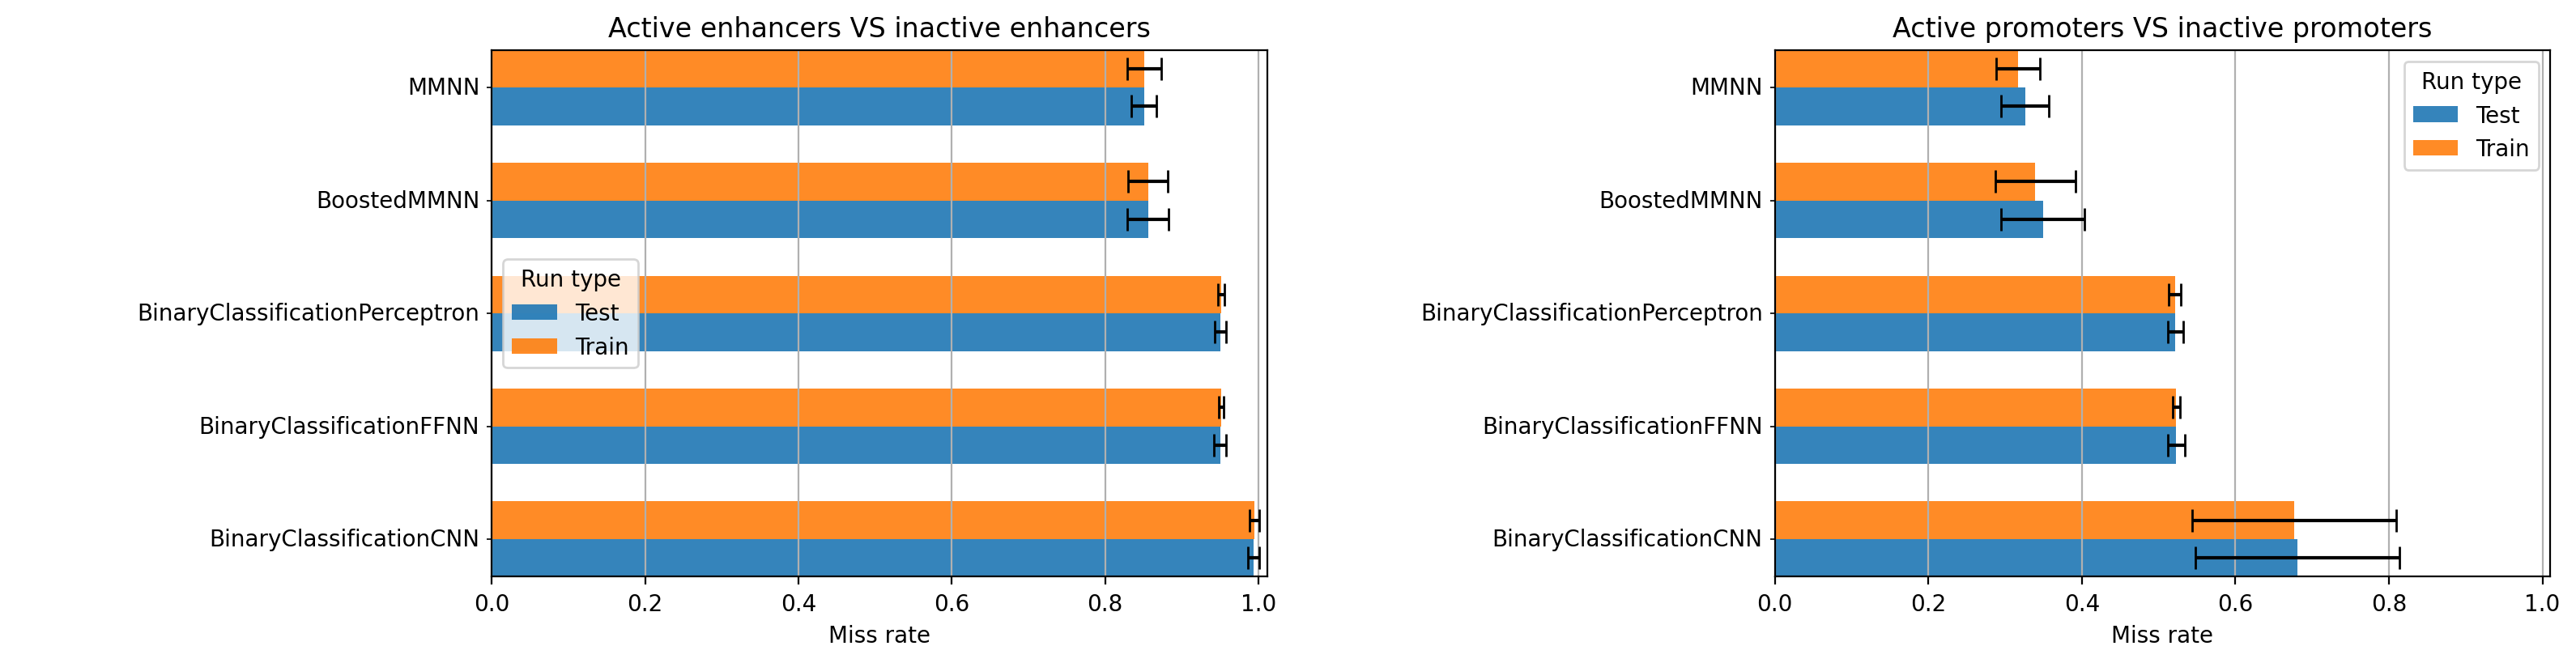

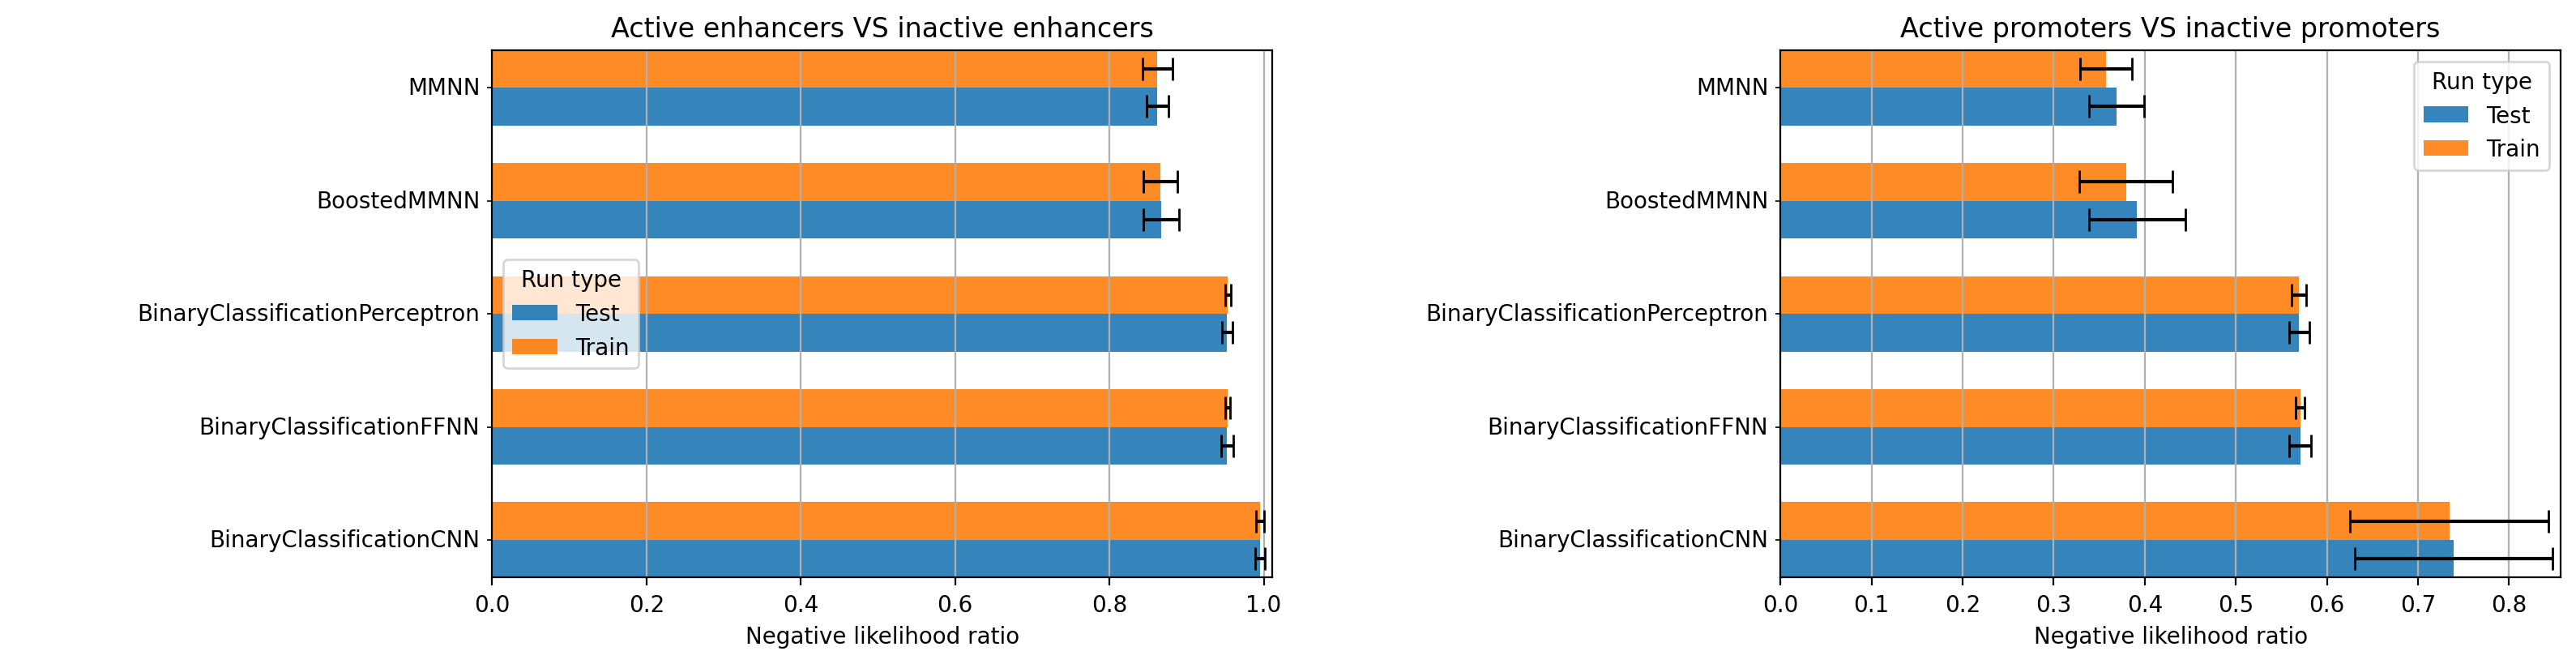

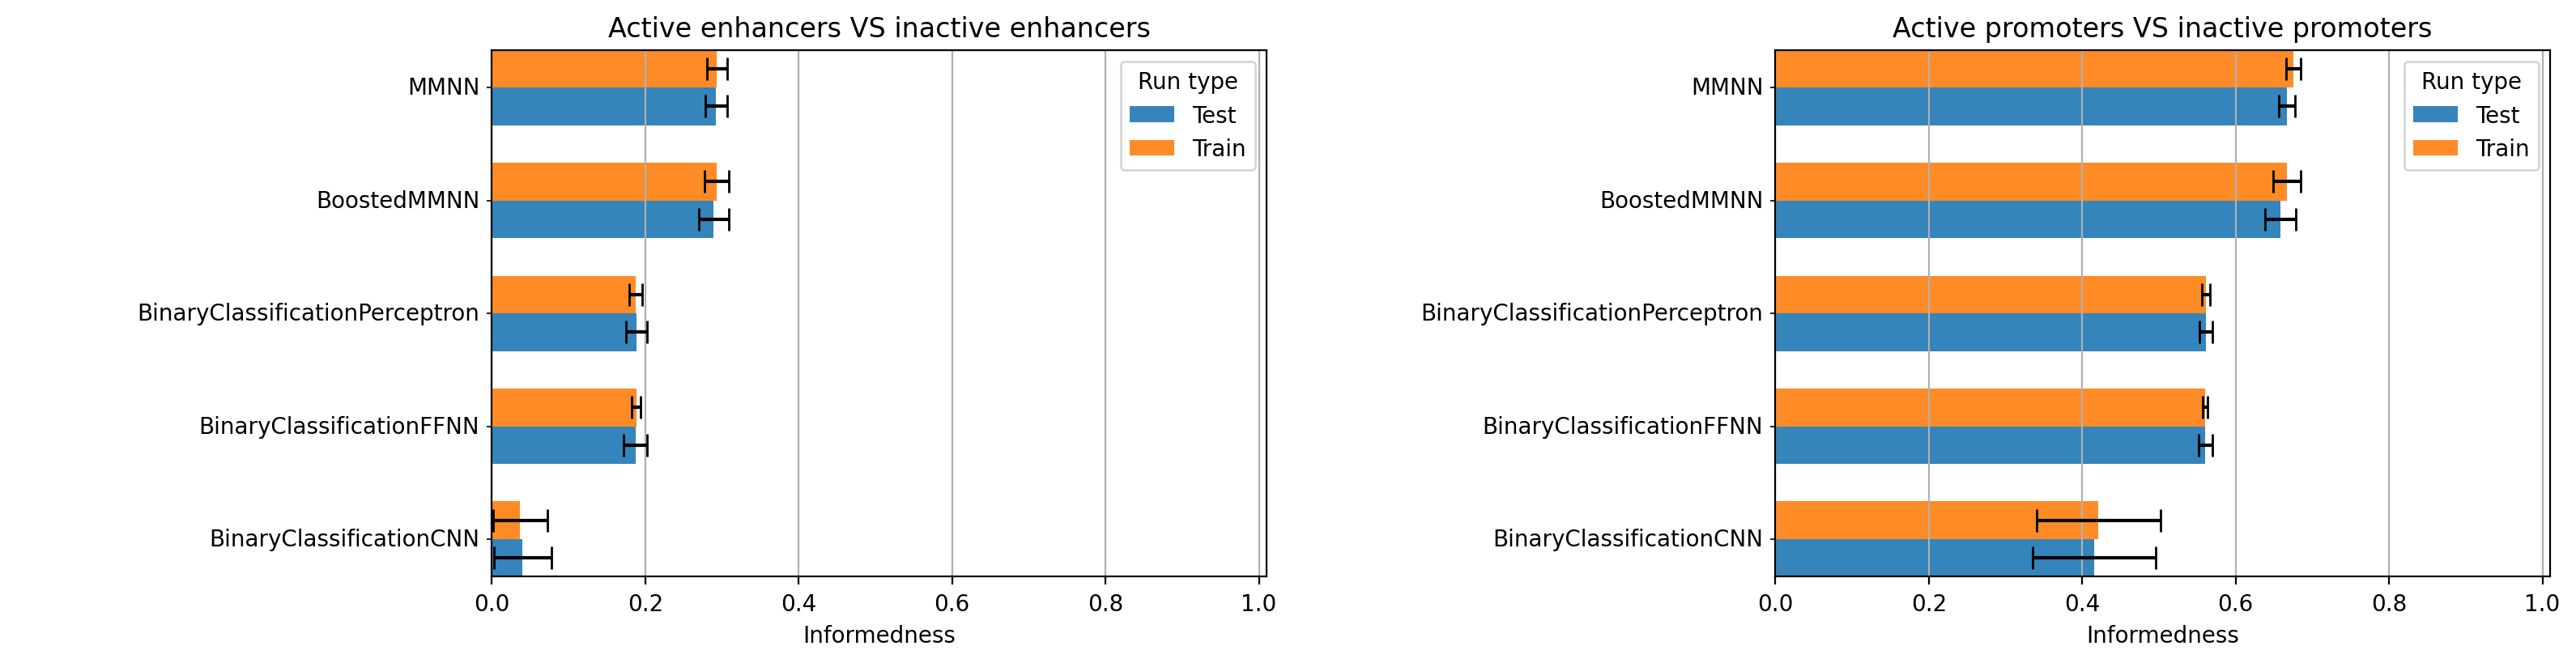

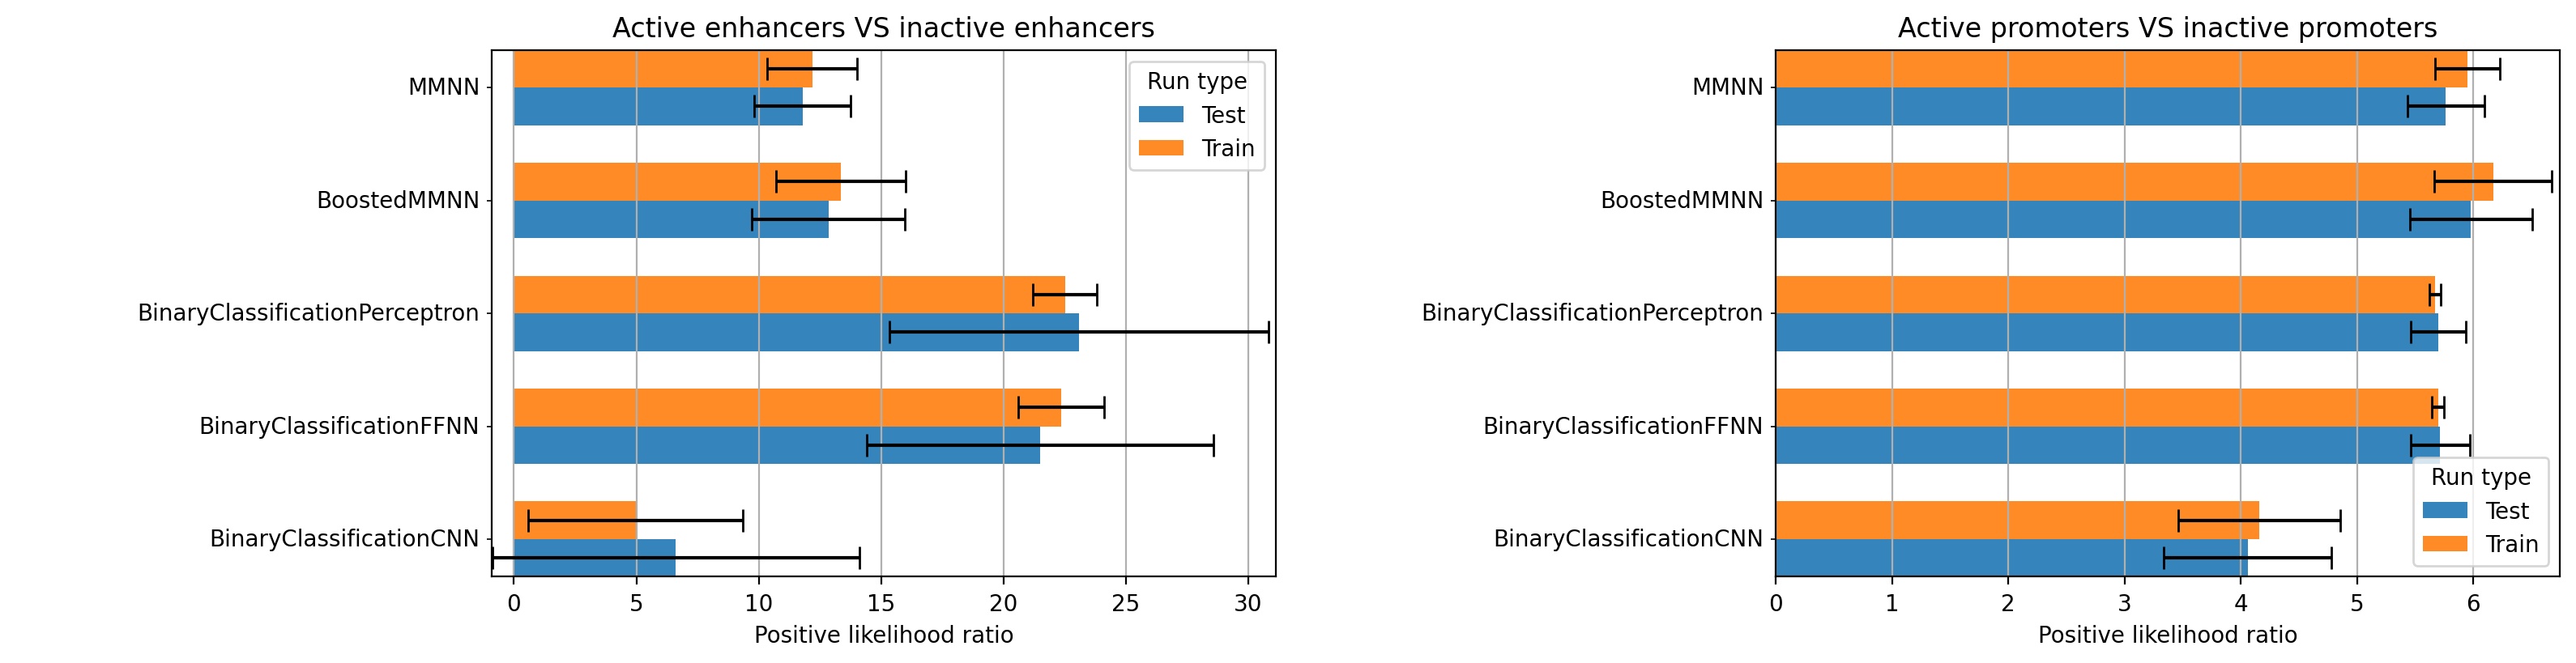

In [21]:
from barplots import barplots

barplots(
    all_binary_classification_performance.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=8,
    subplots=True,
    use_multiprocessing=False
)

# REGRESSION

In [22]:
# Create a list to store all the computed performance
all_regression_performance = []

boruta_features_selected_discarded_regression = {}

# For each task
for task in tqdm((
    active_enhancers_vs_inactive_enhancers,
    active_promoters_vs_inactive_promoters
), desc="Tasks"):
    task_name = task.__name__
    # We get the task data with continuous values
    # and we clip the ys at 10, then normalize
    # these values between 0 and 1.
    X, y = task(
        window_size=window_size,
        cell_line=cell_line
    )
    boruta_features_selected_discarded_regression[task_name] = []
    # Clipping
    y[y>10] = 10
    # Normalizing
    y /= 10
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]
    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(regression_holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        # Feature selection with Boruta
        bor_x = pd.DataFrame(train_X, columns = X.columns)
        kept_features, discarded_features = execute_boruta_feature_selection(bor_x, train_y, holdout_number=holdout_number, regression=False, task_name=str(holdout_number))
        bor_x.drop(discarded_features, inplace=True, axis=1)
        
        test_X = pd.DataFrame(test_X, columns = X.columns)
        test_X.drop(discarded_features, inplace=True, axis=1)
        test_X = test_X.values
        
        # Get the number of features of this specific dataset
        number_of_features = bor_x.shape[1]
        train_X = bor_x.values
        boruta_features_selected_discarded_regression[task_name].append(kept_features)
        boruta_features_selected_discarded_regression[task_name].append(discarded_features)

        perceptron, _, _ = build_regression_perceptron(number_of_features)
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_regression_ffnn(number_of_features)
        cnn, input_sequence_data, last_hidden_cnn = build_regression_cnn(window_size)
        mmnn1 = build_regression_mmnn(number_of_features, window_size)
        mmnn2 = build_regression_mmnn(
            input_sequence_data=input_sequence_data,
            input_epigenomic_data=input_epigenomic_data,
            last_hidden_ffnn=last_hidden_ffnn,
            last_hidden_cnn=last_hidden_cnn
        )
        for model, train_sequence, test_sequence in tqdm(
            (
                (perceptron, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (ffnn, get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y)),
                (cnn, get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y)),
                (mmnn1, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                (mmnn2, get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y)),
            ),
            desc="Training models",
            leave=False
        ):            
            # We compute the model performance
            history, performance = train_model(
                model,
                model.name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number
            )
            # We chain the computed performance to the performance list
            all_regression_performance.append(performance)
        
# We convert the computed performance list into a DataFrame
all_regression_performance = pd.concat(all_regression_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Training models:   0%|          | 0/5 [00:00<?, ?it/s]

Training models:  20%|██        | 1/5 [00:12<00:48, 12.17s/it]

Training models:  40%|████      | 2/5 [00:35<00:56, 18.77s/it]

Training models:  60%|██████    | 3/5 [02:22<01:57, 58.99s/it]

Training models:  80%|████████  | 4/5 [04:12<01:19, 79.03s/it]

Training models: 100%|██████████| 5/5 [06:22<00:00, 97.47s/it]

                                                              
Computing holdouts:  10%|█         | 1/10 [06:49<1:01:25, 409.51s/it]

Training models:   0%|          | 0/5 [00:00<?, ?it/s]

Training models:  20%|██        | 1/5 [00:10<00:40, 10.16s/it]

Training models:  40%|████      | 2/5 [00:17<00:24,  8.21s/it]

Training models:  60%|██████    | 3/5 [02:27<02:07, 63.88s/it]

Training models:  80%|████████  | 4/5 [04:11<01:19, 79.93s/it]

Training models: 100%|██████████| 5/5 [05:56<00:00, 88.90s/it]

                                                      

In [23]:
boruta_features_selected_discarded_regression

{'active_enhancers_vs_inactive_enhancers': [['SP7',
   'SP2',
   'ZNF843',
   'ZNF629',
   'ZBTB11',
   'ZNF580',
   'ZNF175',
   'ZNF558',
   'ZNF514',
   'ZNF48',
   'ZNF10',
   'H3K27ac',
   'PATZ1',
   'ZNF350',
   'ZNF561',
   'ZNF776',
   'ZNF76',
   'ZNF830',
   'PRDM10',
   'ZNF24',
   'ZNF518A',
   'ZBTB20',
   'ZNF248',
   'H3K9me3',
   'ZXDB',
   'ZSCAN4',
   'ZNF555',
   'SALL2',
   'REST',
   'ZBTB26',
   'ZNF610',
   'ZNF324',
   'WT1',
   'ZNF571',
   'ZSCAN23',
   'EGR2',
   'KLF8',
   'KLF16',
   'ZNF274',
   'ZNF473',
   'ZNF639',
   'ZBTB17',
   'SCRT1',
   'ZFP69B',
   'IKZF3',
   'KLF9',
   'ZSCAN21',
   'ZSCAN30',
   'ZNF704',
   'ZBTB8A',
   'ZNF768',
   'ZNF394',
   'BCL6B',
   'ZNF335',
   'ZNF189',
   'GLIS2',
   'REPIN1',
   'ZNF263',
   'ZNF341',
   'PRDM2',
   'ZNF501',
   'MAZ',
   'ZNF521',
   'ZNF596',
   'ZNF2',
   'ZNF677',
   'ZBTB44',
   'PRDM4',
   'ZNF18',
   'ZNF280C',
   'BCL11A',
   'ZNF132',
   'ZNF174',
   'ZNF449',
   'KLF7',
   'ZNF544',
   

In [24]:
all_regression_performance

,loss,mse,run_type,model_name,task,holdout_number
0,0.003230,0.003230,train,RegressionPerceptron,active_enhancers_vs_inactive_enhancers,0
1,0.003144,0.003144,test,RegressionPerceptron,active_enhancers_vs_inactive_enhancers,0
0,0.003582,0.003582,train,RegressionFFNN,active_enhancers_vs_inactive_enhancers,0
1,0.003446,0.003446,test,RegressionFFNN,active_enhancers_vs_inactive_enhancers,0
0,0.000407,0.000407,train,RegressionCNN,active_enhancers_vs_inactive_enhancers,0
...,...,...,...,...,...,...
1,0.082188,0.082188,test,RegressionCNN,active_promoters_vs_inactive_promoters,9
0,0.064215,0.064215,train,RegressionMMNN,active_promoters_vs_inactive_promoters,9
1,0.064410,0.064410,test,RegressionMMNN,active_promoters_vs_inactive_promoters,9
0,0.061328,0.061328,train,BoostedRegressionMMNN,active_promoters_vs_inactive_promoters,9


Rendering barplots: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


((<Figure size 3200x840 with 2 Axes>, <Figure size 3200x840 with 2 Axes>),
 (array([<AxesSubplot:title={'center':'Active enhancers VS inactive enhancers'}, xlabel='MSE'>,
         <AxesSubplot:title={'center':'Active promoters VS inactive promoters'}, xlabel='MSE'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'Active enhancers VS inactive enhancers'}, xlabel='Loss'>,
         <AxesSubplot:title={'center':'Active promoters VS inactive promoters'}, xlabel='Loss'>],
        dtype=object)))

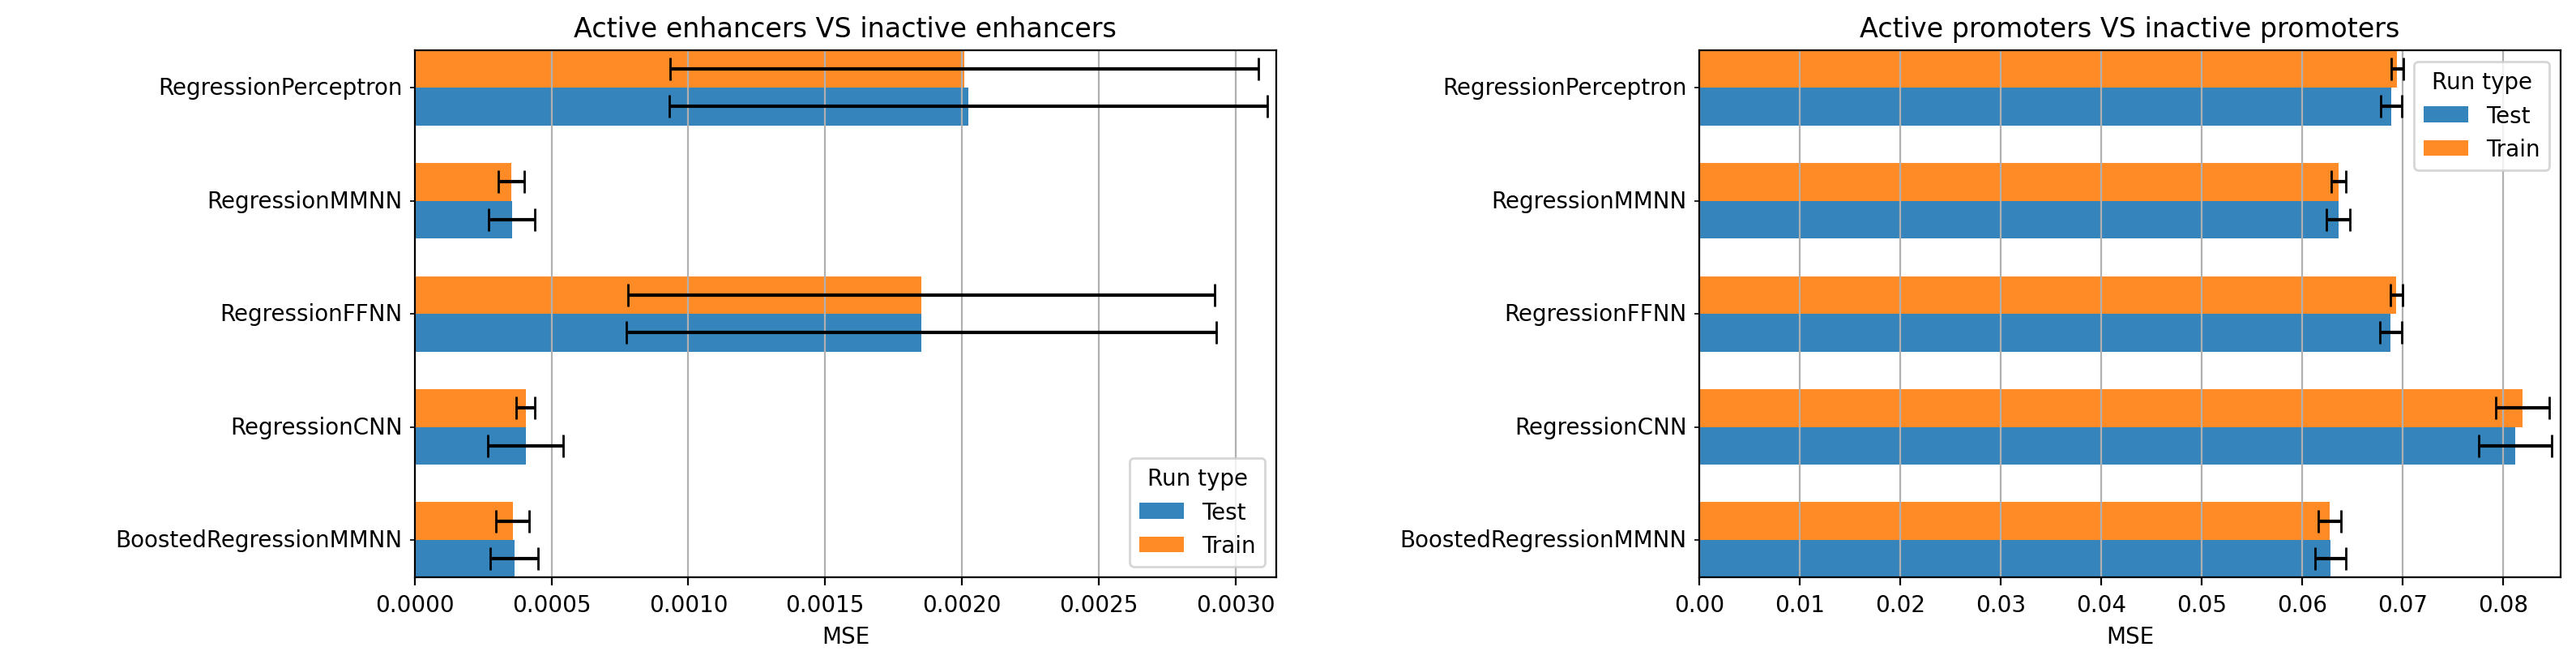

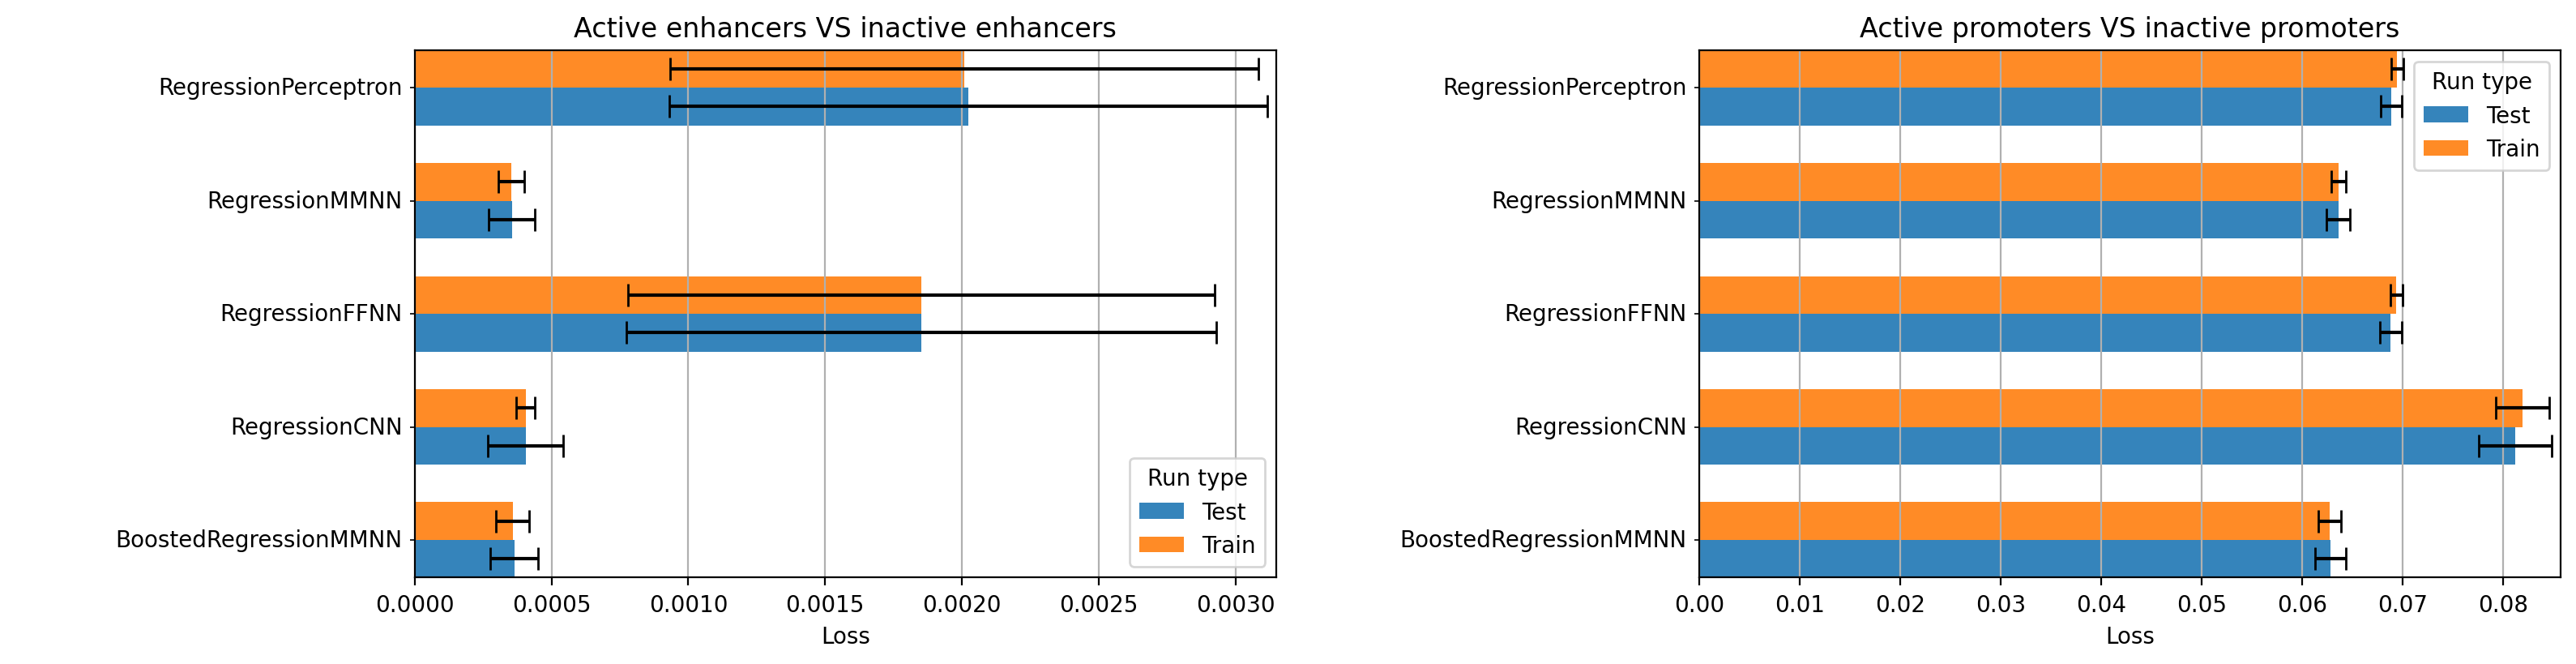

In [25]:
from barplots import barplots

barplots(
    all_regression_performance.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=8,
    subplots=True,
    use_multiprocessing=False
)